In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk


2024-10-18 09:18:50.891682: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-18 09:18:51.136274: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits

In [3]:
def has_duplicates(arr):
    _, counts = np.unique(arr, return_counts=True)
    return np.any(counts > 1)

In [4]:
import math
phi_res = 128/(2*math.pi)
print(phi_res)

20.371832715762604


In [5]:
def load_and_process_normal_data(file_name):
    with h5py.File(file_name, 'r') as hf:
        nmuon, nLRjet, nSRjet, negamma, netau, njtau = 4, 6, 6, 4, 4, 4

        def load_and_scale(dataset, n_objects, scale_factor=10, eta_factor=10, phi_factor = phi_res):
            data = hf[dataset][:, 0:n_objects, :]
            data[:, :, 0] *= scale_factor  # Scale the pT value
            data[:, :, 1] *= eta_factor  # Scale the angle value
            data[:, :, 2] *= phi_factor  # Scale the angle value
            return data.reshape(-1, 3 * n_objects)

        L1_jFexSR_jets = load_and_scale('L1_jFexSR_jets', nSRjet)
        L1_jFexLR_jets = load_and_scale('L1_jFexLR_jets', nLRjet)
        L1_egammas = load_and_scale('L1_egammas', negamma)
        L1_muons = load_and_scale('L1_muons', nmuon, scale_factor=10000)  # Specific scaling for muons
        L1_eFex_taus = load_and_scale('L1_eFex_taus', netau)
        L1_jFex_taus = load_and_scale('L1_jFex_taus', njtau)

        L1_MET = hf['L1_MET'][:]
        L1_MET[:, 0] *= 10
        L1_MET[:, 2] *= phi_res

        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
        EB_weights = hf["EB_weights"][:]
        event_id_signal = hf['event_number'][:]

        if has_duplicates(event_id_signal):
            print("event index show up more than once!!!")
        else:
            print("event index looks good :)")

        # Reformat L1_MET
        L1_MET_fixed = np.zeros((L1_MET.shape[0], 2))
        L1_MET_fixed[:, 0] = L1_MET[:, 0]
        L1_MET_fixed[:, 1] = L1_MET[:, 2]
        L1_MET = L1_MET_fixed

        # Combine arrays into Topo groups
        Topo_2A = np.concatenate([L1_jFexSR_jets, L1_eFex_taus, L1_muons, L1_MET], axis=1)
        Topo_2B = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_jFex_taus, L1_MET], axis=1)
        Topo_3A = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_eFex_taus, L1_MET], axis=1)

        # Handle NaN values
        def fill_median(array):
            for i in range(array.shape[1]):
                median_value = np.nanmedian(array[:, i])
                array[np.isnan(array[:, i]), i] = 0#median_value
            return array

        Topo_2A = fill_median(Topo_2A)
        Topo_2B = fill_median(Topo_2B)
        Topo_3A = fill_median(Topo_3A)

        return Topo_2A, Topo_2B, Topo_3A, pass_L1_unprescaled, pass_HLT_unprescaled, EB_weights, event_id_signal


# Example of how to call the function with a specific number of events
Topo_2A, Topo_2B, Topo_3A, pass_L1_unprescaled, pass_HLT_unprescaled, EB_weights, event_id_signal = load_and_process_normal_data('/eos/home-m/mmcohen/ntuples/EB_ntuples_08-13-2024.h5')

L1_pass_test = pass_L1_unprescaled[625000:800000]
HLT_pass_test = pass_HLT_unprescaled[625000:800000]
L1_pass_flag = pass_L1_unprescaled[450000:800000]
HLT_pass_flag = pass_HLT_unprescaled[450000:800000]
pass_test_event_id = event_id_signal[625000:800000]

Topo_2A_test = Topo_2A[450000:800000,:]
Topo_2B_test = Topo_2B[450000:800000,:]
Topo_3A_test = Topo_3A[450000:800000,:]
test_event_id = event_id_signal[450000:800000]

Topo_test_weights=EB_weights[450000:800000]
    
Topo_2A_test_br = Topo_2A_test[0:175000]
Topo_2A_test_signal = Topo_2A_test[175000:]

Topo_2B_test_br = Topo_2B_test[0:175000]
Topo_2B_test_signal = Topo_2B_test[175000:]

Topo_3A_test_br = Topo_3A_test[0:175000]
Topo_3A_test_signal = Topo_3A_test[175000:]

Topo_br_weights = Topo_test_weights[0:175000]
Topo_signal_weights = Topo_test_weights[175000:]

Topo_br_event_id = event_id_signal[0:175000]
Topo_signal_event_id = event_id_signal[175000:]

print("Shape of Topo_2A_test:", Topo_2A_test.shape)
print("Shape of Topo_2A_test_br:", Topo_2A_test_br.shape)
print("Shape of Topo_2A_test_signal:", Topo_2A_test_signal.shape)

print("Shape of Topo_2B_test:", Topo_2B_test.shape)
print("Shape of Topo_2B_test_br:", Topo_2B_test_br.shape)
print("Shape of Topo_2B_test_signal:", Topo_2B_test_signal.shape)

print("Shape of Topo_3A_test:", Topo_3A_test.shape)
print("Shape of Topo_3A_test_br:", Topo_3A_test_br.shape)
print("Shape of Topo_3A_test_signal:", Topo_3A_test_signal.shape)

event index show up more than once!!!
Shape of Topo_2A_test: (350000, 44)
Shape of Topo_2A_test_br: (175000, 44)
Shape of Topo_2A_test_signal: (175000, 44)
Shape of Topo_2B_test: (350000, 44)
Shape of Topo_2B_test_br: (175000, 44)
Shape of Topo_2B_test_signal: (175000, 44)
Shape of Topo_3A_test: (350000, 44)
Shape of Topo_3A_test_br: (175000, 44)
Shape of Topo_3A_test_signal: (175000, 44)


In [6]:
def load_and_process_anomalous_data(file_name):
    with h5py.File(file_name, 'r') as hf:
        nmuon, nLRjet, nSRjet, negamma, netau, njtau = 4, 6, 6, 4, 4, 4
        print(hf.keys())

        def load_and_scale(dataset, n_objects, scale_factor=10, eta_factor=10, phi_factor = phi_res):
            data = hf[dataset][:, 0:n_objects, :]
            data[:, :, 0] *= scale_factor  # Scale the pT value
            data[:, :, 1] *= eta_factor  # Scale the angle value
            data[:, :, 2] *= phi_factor  # Scale the angle value
            return data.reshape(-1, 3 * n_objects)

        L1_jFexSR_jets = load_and_scale('L1_jFexSR_jets', nSRjet)
        L1_jFexLR_jets = load_and_scale('L1_jFexLR_jets', nLRjet)
        L1_egammas = load_and_scale('L1_egammas', negamma)
        L1_muons = load_and_scale('L1_muons', nmuon, scale_factor=10000)  # Specific scaling for muons
        L1_eFex_taus = load_and_scale('L1_eFex_taus', netau)
        L1_jFex_taus = load_and_scale('L1_jFex_taus', njtau)

        L1_MET = hf['L1_MET'][:]
        L1_MET[:, 0] *= 10
        L1_MET[:, 2] *= phi_res

        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]

        # Reformat L1_MET
        L1_MET_fixed = np.zeros((L1_MET.shape[0], 2))
        L1_MET_fixed[:, 0] = L1_MET[:, 0]
        L1_MET_fixed[:, 1] = L1_MET[:, 2]
        L1_MET = L1_MET_fixed

        # Combine arrays into Topo groups
        Topo_2A = np.concatenate([L1_jFexSR_jets, L1_eFex_taus, L1_muons, L1_MET], axis=1)
        Topo_2B = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_jFex_taus, L1_MET], axis=1)
        Topo_3A = np.concatenate([L1_jFexSR_jets, L1_egammas, L1_eFex_taus, L1_MET], axis=1)

        # Handle NaN values
        def fill_median(array):
            for i in range(array.shape[1]):
                median_value = np.nanmedian(array[:, i])
                array[np.isnan(array[:, i]), i] = 0#median_value
            return array

        Topo_2A = fill_median(Topo_2A)
        Topo_2B = fill_median(Topo_2B)
        Topo_3A = fill_median(Topo_3A)

        return Topo_2A, Topo_2B, Topo_3A, pass_L1_unprescaled

In [7]:
Topo_2A_HHbbtt, Topo_2B_HHbbtt, Topo_3A_HHbbtt, pass_L1_HHbbtt = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/HHbbttHadHad_07-10-2024.h5')
Topo_2A_A14, Topo_2B_A14, Topo_3A_A14, pass_L1_A14 = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/A14N23LO_07-10-2024.h5')
Topo_2A_HAHMggf, Topo_2B_HAHMggf, Topo_3A_HAHMggf, pass_L1_HAHMggf = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/HAHMggfZdZd2l2nu_07-10-2024.h5')
Topo_2A_qqa, Topo_2B_qqa, Topo_3A_qqa, pass_L1_qqa = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/qqa_07-10-2024.h5')
Topo_2A_Zprime, Topo_2B_Zprime, Topo_3A_Zprime, pass_L1_Zprime = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/Zprime2EJs_07-10-2024.h5')
Topo_2A_ZZ4lep, Topo_2B_ZZ4lep, Topo_3A_ZZ4lep, pass_L1_ZZ4lep = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/ZZ4lep_07-10-2024.h5')

<KeysViewHDF5 ['HLT_MET', 'HLT_electrons', 'HLT_jets', 'HLT_muons', 'HLT_photons', 'L1_MET', 'L1_eFex_taus', 'L1_egammas', 'L1_jFexLR_jets', 'L1_jFexSR_jets', 'L1_jFex_taus', 'L1_muons', 'LRT_electrons', 'LRT_muons', 'pass_HLT_unprescaled', 'pass_L1_unprescaled']>
<KeysViewHDF5 ['HLT_MET', 'HLT_electrons', 'HLT_jets', 'HLT_muons', 'HLT_photons', 'L1_MET', 'L1_eFex_taus', 'L1_egammas', 'L1_jFexLR_jets', 'L1_jFexSR_jets', 'L1_jFex_taus', 'L1_muons', 'LRT_electrons', 'LRT_muons', 'pass_HLT_unprescaled', 'pass_L1_unprescaled']>
<KeysViewHDF5 ['HLT_MET', 'HLT_electrons', 'HLT_jets', 'HLT_muons', 'HLT_photons', 'L1_MET', 'L1_eFex_taus', 'L1_egammas', 'L1_jFexLR_jets', 'L1_jFexSR_jets', 'L1_jFex_taus', 'L1_muons', 'LRT_electrons', 'LRT_muons', 'pass_HLT_unprescaled', 'pass_L1_unprescaled']>
<KeysViewHDF5 ['HLT_MET', 'HLT_electrons', 'HLT_jets', 'HLT_muons', 'HLT_photons', 'L1_MET', 'L1_eFex_taus', 'L1_egammas', 'L1_jFexLR_jets', 'L1_jFexSR_jets', 'L1_jFex_taus', 'L1_muons', 'LRT_electrons', '

In [8]:
#Here I section off some additional signals
Topo_2A_HLT_passed = Topo_2A_test_signal[HLT_pass_test == 1]
Topo_2A_L1_passed = Topo_2A_test_signal[L1_pass_test == 1]
Topo_2A_just_L1_passed = Topo_2A_L1_passed[HLT_pass_test[L1_pass_test == 1] == 0]

Topo_2B_HLT_passed = Topo_2B_test_signal[HLT_pass_test == 1]
Topo_2B_L1_passed = Topo_2B_test_signal[L1_pass_test == 1]
Topo_2B_just_L1_passed = Topo_2B_L1_passed[HLT_pass_test[L1_pass_test == 1] == 0]

Topo_3A_HLT_passed = Topo_3A_test_signal[HLT_pass_test == 1]
Topo_3A_L1_passed = Topo_3A_test_signal[L1_pass_test == 1]
Topo_3A_just_L1_passed = Topo_3A_L1_passed[HLT_pass_test[L1_pass_test == 1] == 0]

In [9]:
Topo_2A_L1failed = Topo_2A_test[L1_pass_flag == 0]
Topo_EB_weights = EB_weights[450000:800000]
Topo_EB_L1failed_weights = Topo_EB_weights[L1_pass_flag == 0]
print(np.sum(L1_pass_flag)/len(L1_pass_flag))

Topo_HLT_weights = Topo_signal_weights[HLT_pass_test == 1]
Topo_L1_weights = Topo_signal_weights[L1_pass_test == 1]

0.18456571428571428


In [10]:
Topo_2A_jz1, Topo_2B_jz1, Topo_3A_jz1, pass_L1_jz1 = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/jjJZ1_07-10-2024.h5')
Topo_2A_jz2, Topo_2B_jz2, Topo_3A_jz2, pass_L1_jz2 = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/jjJZ2_07-10-2024.h5')
Topo_2A_jz4, Topo_2B_jz4, Topo_3A_jz4, pass_L1_jz4 = load_and_process_anomalous_data('/eos/home-m/mmcohen/ntuples/MC_07-10-2024/jjJZ4_07-10-2024.h5')

<KeysViewHDF5 ['HLT_MET', 'HLT_electrons', 'HLT_jets', 'HLT_muons', 'HLT_photons', 'L1_MET', 'L1_eFex_taus', 'L1_egammas', 'L1_jFexLR_jets', 'L1_jFexSR_jets', 'L1_jFex_taus', 'L1_muons', 'LRT_electrons', 'LRT_muons', 'pass_HLT_unprescaled', 'pass_L1_unprescaled']>
<KeysViewHDF5 ['HLT_MET', 'HLT_electrons', 'HLT_jets', 'HLT_muons', 'HLT_photons', 'L1_MET', 'L1_eFex_taus', 'L1_egammas', 'L1_jFexLR_jets', 'L1_jFexSR_jets', 'L1_jFex_taus', 'L1_muons', 'LRT_electrons', 'LRT_muons', 'pass_HLT_unprescaled', 'pass_L1_unprescaled']>
<KeysViewHDF5 ['HLT_MET', 'HLT_electrons', 'HLT_jets', 'HLT_muons', 'HLT_photons', 'L1_MET', 'L1_eFex_taus', 'L1_egammas', 'L1_jFexLR_jets', 'L1_jFexSR_jets', 'L1_jFex_taus', 'L1_muons', 'LRT_electrons', 'LRT_muons', 'pass_HLT_unprescaled', 'pass_L1_unprescaled']>


In [11]:
Topo_2A_HHbbtt_pure = Topo_2A_HHbbtt[pass_L1_HHbbtt==0]
Topo_2A_A14_pure = Topo_2A_A14[pass_L1_A14==0]
Topo_2A_HAHMggf_pure = Topo_2A_HAHMggf[pass_L1_HAHMggf==0]
Topo_2A_qqa_pure = Topo_2A_qqa[pass_L1_qqa==0]
Topo_2A_Zprime_pure = Topo_2A_Zprime[pass_L1_Zprime==0]
Topo_2A_ZZ4lep_pure = Topo_2A_ZZ4lep[pass_L1_ZZ4lep==0]
Topo_2A_jz1_pure = Topo_2A_jz1[pass_L1_jz1==0]
Topo_2A_jz2_pure = Topo_2A_jz2[pass_L1_jz2==0]
Topo_2A_jz4_pure = Topo_2A_jz4[pass_L1_jz4==0]

In [12]:
def calculate_percentage(original, filtered):
    return (len(filtered) / len(original)) * 100 if len(original) > 0 else 0

datasets = [
    ("Topo_2A_HHbbtt", Topo_2A_HHbbtt, Topo_2A_HHbbtt_pure),
    ("Topo_2A_A14", Topo_2A_A14, Topo_2A_A14_pure),
    ("Topo_2A_HAHMggf", Topo_2A_HAHMggf, Topo_2A_HAHMggf_pure),
    ("Topo_2A_qqa", Topo_2A_qqa, Topo_2A_qqa_pure),
    ("Topo_2A_Zprime", Topo_2A_Zprime, Topo_2A_Zprime_pure),
    ("Topo_2A_ZZ4lep", Topo_2A_ZZ4lep, Topo_2A_ZZ4lep_pure),
    ("Topo_2A_jz1", Topo_2A_jz1, Topo_2A_jz1_pure),
    ("Topo_2A_jz2", Topo_2A_jz2, Topo_2A_jz2_pure),
    ("Topo_2A_jz4", Topo_2A_jz4, Topo_2A_jz4_pure)
]

# Dictionary to store percentages
filter_percentages = {}

for name, original, filtered in datasets:
    percentage = calculate_percentage(original, filtered)
    filter_percentages[name] = percentage
    print(f"{name}: {percentage:.2f}% passed the filter")

Topo_2A_HHbbtt: 5.41% passed the filter
Topo_2A_A14: 63.84% passed the filter
Topo_2A_HAHMggf: 29.16% passed the filter
Topo_2A_qqa: 39.67% passed the filter
Topo_2A_Zprime: 0.02% passed the filter
Topo_2A_ZZ4lep: 9.73% passed the filter
Topo_2A_jz1: 94.21% passed the filter
Topo_2A_jz2: 62.31% passed the filter
Topo_2A_jz4: 0.00% passed the filter


In [13]:
print(len(EB_weights))
print(len(pass_L1_unprescaled))
print(len(pass_HLT_unprescaled))
passed_none=0
passed_L1=0
passed_hlt=0
passed_just_L1=0
passed_just_hlt=0
for i in range(0,len(EB_weights)):
    if pass_L1_unprescaled[i]==0 and pass_HLT_unprescaled[i]==0:
        passed_none+=1
    if pass_L1_unprescaled[i]==1 and pass_HLT_unprescaled[i]==0:
        passed_just_L1+=1
    if pass_L1_unprescaled[i]==1:
        passed_L1+=1
    if pass_L1_unprescaled[i]==0 and pass_HLT_unprescaled[i]==1:
        passed_just_hlt+=1
    if pass_HLT_unprescaled[i]==1:
        passed_hlt+=1

print('__Triggers__    __Num Passed__')
print('    none          {}'.format(passed_none))
print('     L1           {}'.format(passed_L1))
print('   Just L1        {}'.format(passed_just_L1))
print('     HLT          {}'.format(passed_hlt))
print('   Just HLT       {}'.format(passed_just_hlt))
print('L1- Just L1       {}'.format(passed_L1-passed_just_L1))
print('HLT-Just HLT      {}'.format(passed_hlt-passed_just_hlt))
    

2104833
2104833
2104833
__Triggers__    __Num Passed__
    none          1501034
     L1           603486
   Just L1        588544
     HLT          15255
   Just HLT       313
L1- Just L1       14942
HLT-Just HLT      14942


In [14]:

def check_empty_arrays(*arrays):
    """
    Check if any of the input arrays are empty and print the results.
    
    Args:
    *arrays: Variable number of arrays to check
    
    Returns:
    bool: True if any array is empty, False otherwise
    """
    empty_found = False
    for i, arr in enumerate(arrays):
        if isinstance(arr, np.ndarray) and arr.size == 0:
            print(f"Array {i} is empty")
            empty_found = True
        elif isinstance(arr, np.ndarray):
            print(f"Array {i} shape: {arr.shape}")
        else:
            print(f"Item {i} is not a numpy array")
    
    return empty_found
empty_arrays = check_empty_arrays(
    Topo_2A_test_br, Topo_2A_test_signal, Topo_2A_HLT_passed, Topo_2A_L1_passed,
    Topo_2A_HHbbtt, Topo_2A_jz1, Topo_2A_jz2, Topo_2A_jz4, Topo_2A_A14,
    Topo_2A_HAHMggf, Topo_2A_qqa, Topo_2A_Zprime, Topo_2A_ZZ4lep
)

if empty_arrays:
    print("Warning: Some arrays are empty after filtering!")
else:
    print("All arrays have data after filtering.")

Array 0 shape: (175000, 44)
Array 1 shape: (175000, 44)
Array 2 shape: (791, 44)
Array 3 shape: (32182, 44)
Array 4 shape: (350000, 44)
Array 5 shape: (1000000, 44)
Array 6 shape: (1000000, 44)
Array 7 shape: (650000, 44)
Array 8 shape: (10000, 44)
Array 9 shape: (70000, 44)
Array 10 shape: (50000, 44)
Array 11 shape: (100000, 44)
Array 12 shape: (100000, 44)
All arrays have data after filtering.


In [15]:
def find_min_max_abs(arr):
    """
    Find the minimum and maximum of the absolute values in an array.
    
    Args:
    arr (numpy.ndarray): Input array (1D or 2D)
    
    Returns:
    tuple: (min_abs, max_abs) - The minimum and maximum of the absolute values
    """
    # Convert to numpy array if it's not already
    arr = np.asarray(arr)
    # Compute the absolute values
    abs_arr = np.abs(arr.flatten())
    masked_arr = np.ma.masked_equal(abs_arr, 0)

    # Find the min and max
    min_abs = np.min(masked_arr)
    max_abs = np.max(abs_arr)
    
    print(f"Minimum absolute value: {min_abs}")
    print(f"Maximum absolute value: {max_abs}")
# find_min_max_abs(Topo_2A_test_br)
# find_min_max_abs(Topo_2A_Zprime)

find_min_max_abs(Topo_2A_test_br[:,0])
find_min_max_abs(Topo_2A_test_br[:,18])
find_min_max_abs(Topo_2A_test_br[:,30])
find_min_max_abs(Topo_2A_test_br[:,-2])

# List of arrays
arrays = [
    Topo_2A_test_br, Topo_2A_test_signal, Topo_2A_HLT_passed, Topo_2A_L1_passed,
    Topo_2A_HHbbtt, Topo_2A_jz1, Topo_2A_jz2, Topo_2A_jz4, Topo_2A_A14,
    Topo_2A_HAHMggf, Topo_2A_qqa, Topo_2A_Zprime, Topo_2A_ZZ4lep
]

# List of array names (for printing purposes)
array_names = [
    "Topo_2A_test_br", "Topo_2A_test_signal", "Topo_2A_HLT_passed", "Topo_2A_L1_passed",
    "Topo_2A_HHbbtt", "Topo_2A_jz1", "Topo_2A_jz2", "Topo_2A_jz4", "Topo_2A_A14",
    "Topo_2A_HAHMggf", "Topo_2A_qqa", "Topo_2A_Zprime", "Topo_2A_ZZ4lep"
]

# Columns to check
columns = [0,1,2,3,4,5, 18, 30, -2]

# Process all arrays
for array, name in zip(arrays, array_names):
    print(f"\nResults for {name}:")
    for col in columns:
        print(f"Column {col}:")
        find_min_max_abs(array[:, col])

Minimum absolute value: 151.99999809265137
Maximum absolute value: 4093.9999389648438
Minimum absolute value: 50.0
Maximum absolute value: 4095.0
Minimum absolute value: 30.00000026077032
Maximum absolute value: 199.99999552965164
Minimum absolute value: 2.0000000298023224
Maximum absolute value: 2963.3932495117188

Results for Topo_2A_test_br:
Column 0:
Minimum absolute value: 151.99999809265137
Maximum absolute value: 4093.9999389648438
Column 1:
Minimum absolute value: 0.5000000074505806
Maximum absolute value: 47.823381423950195
Column 2:
Minimum absolute value: 1.000000103718526
Maximum absolute value: 62.99999894516806
Column 3:
Minimum absolute value: 151.99999809265137
Maximum absolute value: 4093.9999389648438
Column 4:
Minimum absolute value: 0.5000000074505806
Maximum absolute value: 47.823381423950195
Column 5:
Minimum absolute value: 1.000000103718526
Maximum absolute value: 62.99999894516806
Column 18:
Minimum absolute value: 50.0
Maximum absolute value: 4095.0
Column 30:

Minimum absolute value: 30.00000026077032
Maximum absolute value: 199.99999552965164
Column -2:
Minimum absolute value: 66.2419843673706
Maximum absolute value: 24828.4912109375

Results for Topo_2A_qqa:
Column 0:
Minimum absolute value: 101.99999809265137
Maximum absolute value: 4093.9999389648438
Column 1:
Minimum absolute value: 0.5000000074505806
Maximum absolute value: 45.675387382507324
Column 2:
Minimum absolute value: 0.9999895548708079
Maximum absolute value: 62.99999894516806
Column 3:
Minimum absolute value: 51.99999809265137
Maximum absolute value: 4093.9999389648438
Column 4:
Minimum absolute value: 0.5000000074505806
Maximum absolute value: 47.79160022735596
Column 5:
Minimum absolute value: 0.9999895548708079
Maximum absolute value: 62.99999894516806
Column 18:
Minimum absolute value: 61.99999809265137
Maximum absolute value: 4095.0
Column 30:
Minimum absolute value: 30.00000026077032
Maximum absolute value: 199.99999552965164
Column -2:
Minimum absolute value: 313.46450

In [16]:
# jet_pt = np.percentile(np.ma.masked_equal(Topo_2A_test_br[:, 0], 0).compressed(), 99.99)
# tau_pt = np.percentile(np.ma.masked_equal(Topo_2A_test_br[:, 18], 0).compressed(), 99.99)
# muon_pt = np.percentile(np.ma.masked_equal(Topo_2A_test_br[:, 30], 0).compressed(), 99.99)
# met = np.percentile(np.ma.masked_equal(Topo_2A_test_br[:, -2], 0).compressed(), 99.99)
# print(jet_pt, tau_pt, muon_pt, met)

In [17]:
# def large_value_filter(input_data, weight):
#     mask = (input_data[:, -2] <= met) & (input_data[:, 0] <= jet_pt) & (input_data[:, 18] <= tau_pt) & (input_data[:, 30] <= muon_pt)
#     return input_data[mask], weight[mask]
# def large_value_filter_now(input_data):
#     mask = (input_data[:, -2] <= met) & (input_data[:, 0] <= jet_pt) & (input_data[:, 18] <= tau_pt) & (input_data[:, 30] <= muon_pt)
#     return input_data[mask]
# Topo_HLT_weights = Topo_signal_weights[HLT_pass_test==1]
# Topo_L1_weights = Topo_signal_weights[L1_pass_test==1]
# Topo_2A_test_br, Topo_br_weights = large_value_filter(Topo_2A_test_br, Topo_br_weights)
# Topo_2A_test_signal, Topo_signal_weights = large_value_filter(Topo_2A_test_signal, Topo_signal_weights)
# Topo_2A_HLT_passed, Topo_HLT_weights = large_value_filter(Topo_2A_HLT_passed, Topo_HLT_weights)
# Topo_2A_L1_passed, Topo_L1_weights = large_value_filter(Topo_2A_L1_passed, Topo_L1_weights)
# Topo_2A_HHbbtt = large_value_filter_now(Topo_2A_HHbbtt)
# Topo_2A_jz1 = large_value_filter_now(Topo_2A_jz1)
# Topo_2A_jz2 = large_value_filter_now(Topo_2A_jz2)
# Topo_2A_jz4 = large_value_filter_now(Topo_2A_jz4)
# Topo_2A_A14 = large_value_filter_now(Topo_2A_A14)
# Topo_2A_HAHMggf = large_value_filter_now(Topo_2A_HAHMggf)
# Topo_2A_qqa = large_value_filter_now(Topo_2A_qqa)
# Topo_2A_Zprime = large_value_filter_now(Topo_2A_Zprime)
# Topo_2A_ZZ4lep = large_value_filter_now(Topo_2A_ZZ4lep)


In [18]:

empty_arrays = check_empty_arrays(
    Topo_2A_test_br, Topo_2A_test_signal, Topo_2A_HLT_passed, Topo_2A_L1_passed,
    Topo_2A_HHbbtt, Topo_2A_jz1, Topo_2A_jz2, Topo_2A_jz4, Topo_2A_A14,
    Topo_2A_HAHMggf, Topo_2A_qqa, Topo_2A_Zprime, Topo_2A_ZZ4lep,
    Topo_br_weights, Topo_signal_weights, Topo_HLT_weights, Topo_L1_weights
)

if empty_arrays:
    print("Warning: Some arrays are empty after filtering!")
else:
    print("All arrays have data after filtering.")

Array 0 shape: (175000, 44)
Array 1 shape: (175000, 44)
Array 2 shape: (791, 44)
Array 3 shape: (32182, 44)
Array 4 shape: (350000, 44)
Array 5 shape: (1000000, 44)
Array 6 shape: (1000000, 44)
Array 7 shape: (650000, 44)
Array 8 shape: (10000, 44)
Array 9 shape: (70000, 44)
Array 10 shape: (50000, 44)
Array 11 shape: (100000, 44)
Array 12 shape: (100000, 44)
Array 13 shape: (175000,)
Array 14 shape: (175000,)
Array 15 shape: (791,)
Array 16 shape: (32182,)
All arrays have data after filtering.


In [16]:
class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def Qmake_encoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs = keras.Input(shape=(input_dim), name = "inputs")
    x = QDense(h_dim_1,
            kernel_quantizer=quantized_bits(10,5,0,alpha=1),
            bias_quantizer=quantized_bits(10,5,0,alpha=1),
            name = "dense1")(inputs)
    x = QBatchNormalization(name="BN1")(x)
    x = QActivation(quantized_relu(15, negative_slope=1/1024), name = 'relu1')(x)
    x = QDense(h_dim_2,
            kernel_quantizer=quantized_bits(10,5,0,alpha=1),
            bias_quantizer=quantized_bits(10,5,0,alpha=1),
            name = "dense2")(x)
    x = QBatchNormalization(name="BN2")(x)
    x = QActivation(quantized_relu(15, negative_slope=1/1024), name = 'relu2')(x)
    z_mean = QDense(latent_dim, name='z_mean',
                  kernel_quantizer=quantized_bits(10,5,0,alpha=1),
                  bias_quantizer=quantized_bits(10,5,0,alpha=1))(x)
    z_logvar = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean,z_logvar])
    encoder = keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder

def Qmake_decoder_set_weights(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs = keras.Input(shape=(latent_dim))
    x = layers.Dense(h_dim_2, activation='relu')(inputs)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    z = layers.Dense(input_dim)(x)
    decoder = keras.Model(inputs,z,name='decoder')
    return decoder

class VAE_Model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta=1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_beta(self,beta):
        self.beta=beta
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #making a masked loss function
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
            reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta


            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        #reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(mask*data, mask*reconstruction))
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        
        #KL loss changed abck to sum as in paper
        #kl_loss = tf.reduce_sum(kl_loss)
        kl_loss = tf.reduce_mean(kl_loss)
        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

In [17]:
from scipy import stats

def total_loss(signal, predict, z_mean, z_log_var, beta):
    re_loss = np.mean((signal - predict) ** 2)
    kl_loss = np.sum(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    tot_loss = re_loss + beta * kl_loss
    return tot_loss

def AD_score(s, p, z_m, z_log, beta):
    mask = s != 0

    _s = s * mask
    _p = p * mask

    p = mask * p
    return total_loss(_s, _p, z_m, z_log, beta)


def AD_score_MSE(s, p):
    mask = s != 0
    s1 = s * mask
    p1 = p * mask
    re_loss = np.mean((s1 - p1) ** 2)
    return re_loss


def AD_score_KL(z_mean, z_log_var):
    kl_loss = np.mean(-0.5 * (1 + z_log_var - (z_mean) ** 2 - np.exp(z_log_var)))
    return kl_loss


def AD_score_Rz(z_mean, z_log_var):
    Rz_loss = np.mean((z_mean**2) / (np.exp(z_log_var)))
    return Rz_loss


def AD_score_CKL(z_mean, z_log_var):
    CKL = np.mean(z_mean**2)
    return CKL


class Model_Evaluator:
    def __init__(
        self,
        model_path,
        backround,
        br_weights,
        signal,
        signal_weights,
        input_dim,
        title="placeholder",
        save=False,
        labels=None,
    ):

        self.input_dim = input_dim
        #vae_enc = make_encoder_set_weights(input_dim, 32, 16, 3)
        #vae_dec = make_decoder_set_weights(input_dim, 32, 16, 3)
        vae_enc = Qmake_encoder_set_weights(input_dim, 32, 16, 3)
        vae_dec = Qmake_decoder_set_weights(input_dim, 32, 16, 3)
        self.model = VAE_Model(vae_enc, vae_dec)
        self.model.load_weights(model_path)
        self.encoder = self.model.get_layer("encoder")
        self.signal = signal
        self.backround = backround
        self.br_loss = []
        self.signal_loss = []
        self.backround_outputs = []
        self.signal_outputs = []
        self.title = title
        self.saveplots = save
        self.labels = labels
        self.latent_info = []
        self.br_weights = br_weights
        self.signal_weights = signal_weights

    def calculate_loss(self, l_type):
        self.signal_loss = []
        self.br_loss = []
        br = self.backround

        if l_type == "CKL":
            br_latent = np.array(self.encoder.predict(br))
            self.latent_info += [br_latent[0]]
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_CKL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))
                self.latent_info += [sg_latent[0]]
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_CKL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "KL":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_KL(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_KL(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "Rz":
            br_latent = np.array(self.encoder.predict(br))
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_Rz(br_latent[0][i], br_latent[1][i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_latent = np.array(self.encoder.predict(batch))

                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_Rz(sg_latent[0][i], sg_latent[1][i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        if l_type == "MSE":
            br_predict = np.array(self.model.predict(br)["reconstruction"])
            l = []
            for i in range(0, br.shape[0]):
                loss = AD_score_MSE(br[i], br_predict[i])
                l += [loss]
            self.br_loss = l

            for i, batch in enumerate(self.signal):
                sg_predict = np.array(self.model.predict(batch)["reconstruction"])
                l = []

                for i in range(0, batch.shape[0]):
                    loss = AD_score_MSE(batch[i], sg_predict[i])
                    l += [loss]

                sg_loss = l

                self.signal_loss += [sg_loss]

        return [self.br_loss, self.signal_loss]

    def histogram(self, bins):
        plt.hist(
            self.br_loss,
            weights=self.br_weights,
            bins=bins,
            histtype="step",
            label="backround num_events:{}".format(len(self.br_loss)),
        )
        for i, batch in enumerate(self.signal_loss):
            plt.hist(
                batch,
                weights=self.signal_weights[i],
                bins=bins,
                histtype="step",
                label=str(self.labels[i]) + " num_events:{}".format(len(batch)),
            )
        plt.xlabel("loss")
        plt.ylabel("Frequency")
        plt.yscale("log")
        plt.title("{}_Hist".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_Hist.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def ROC(self):
        target_fpr = 2.5e-5/(1-0.18456571428571428)
        tpr_at_target = []
        thresholds_at_target = []

        plt.plot(
            ((1-0.18456571428571428)*40000000)*np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal"
        )
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, thresholds = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr*(1-0.18456571428571428)*40000000, tpr, label=self.labels[j] + ": " + str(round(auc, 3)))
            
            idx = np.argmin(np.abs(fpr - target_fpr))
            tpr_at_target.append(tpr[idx])
            thresholds_at_target.append(thresholds[idx])

        plt.xlabel("Trigger frequency [Hz]")
        plt.semilogx()
        plt.ylabel("tpr")
        plt.grid()
        plt.semilogy()
        plt.title("{}_ROC".format(self.title))
        plt.vlines(1e3, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_ROC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()
        
        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        for label, tpr, threshold in zip(self.labels, tpr_at_target, thresholds_at_target):
            print(f"{label}: {100*tpr:.4f}%, Theshold = {threshold:.6f}")


    def GetPerformance(self):
        target_fpr = 2.5e-5/(1-0.18456571428571428)
        tpr_at_target = []

        print(f"Number of signal losses: {len(self.signal_loss)}")
        print(f"Number of labels: {len(self.labels)}")
        print(f"Number of signal weights: {len(self.signal_weights)}")
        print(f"Length of br_loss: {len(self.br_loss)}")

        plt.figure(figsize=(10, 6))
        plt.plot((1-0.18456571428571428)*40000000*np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), "--", label="diagonal")

        for j, batch in enumerate(self.signal_loss):
            print(f"Processing batch {j}")
            print(f"Batch length: {len(batch)}")
            print(f"Signal weight length: {len(self.signal_weights[j])}")

            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = np.concatenate([np.zeros(len(self.br_loss)), np.ones(len(batch))])
            ROC_data = np.concatenate((self.br_loss, batch))

            print(f"ROC_data shape: {ROC_data.shape}")
            print(f"truth shape: {truth.shape}")
            print(f"weights shape: {weights.shape}")

            try:
                fpr, tpr, _ = sk.roc_curve(truth, ROC_data, sample_weight=weights)
                auc = sk.roc_auc_score(truth, ROC_data)

                plt.plot(fpr*(1-0.18456571428571428)*40000000, tpr, label=f"{self.labels[j]}: {auc:.3f}")

                idx = np.argmin(np.abs(fpr - target_fpr))
                tpr_at_target.append(tpr[idx])

                print(f"Successfully processed batch {j}")
            except Exception as e:
                print(f"Error processing batch {j}: {str(e)}")

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f"{self.title} ROC")
        plt.vlines(1e3, 0, 1, colors="r", linestyles="dashed")
        plt.legend(loc="lower right")
        if self.saveplots:
            plt.savefig(
                f"/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{self.title}_ROC.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        print(f"\nTPR at FPR = {target_fpr} for each channel:")
        results = list(zip(self.labels, tpr_at_target))
        for label, tpr in results:
            print(f"{label}: {tpr*100:.6f}%")

        print(f"Number of results: {len(results)}")
        return results

    def weighted_S_F(self, rate1):
        sf_list = []
        for j, batch in enumerate(self.signal_loss):
            sig_w = self.signal_weights[j]
            br_w = self.br_weights
            weights = np.concatenate((br_w, sig_w))
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, x = sk.roc_curve(truth, ROC_data, sample_weight=weights)
            # auc=np.trapz(tpr,fpr)
            saved = 0
            saved_index = 0
            for k, f in enumerate(fpr):
                if f > saved and f <= rate1:
                    saved = f
                    saved_index = k
            sf_list += [tpr[saved_index]]
        return sf_list

    def Plot_3D(self):
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
        for i, signal in enumerate(self.latent_info):
            sig_tuple = np.array(signal)
            print(sig_tuple.shape)
            x = sig_tuple[0:100, 0]
            y = sig_tuple[0:100, 1]
            z = sig_tuple[0:100, 2]
            ax.scatter(x, y, z, label=self.labels[i], marker=".")
        plt.legend()
        plt.show()

    def Plot_2D(self):
        # xy
        for i, signal in enumerate(self.latent_info[1:]):
            sig_tuple = np.array(signal)
            x = sig_tuple[:, 0]
            y = sig_tuple[:, 1]
            plt.plot(x, y, "o", label=self.labels[i], alpha=0.5)
        sig_tuple_br = np.array(self.latent_info[0])
        x = sig_tuple_br[:, 0]
        y = sig_tuple_br[:, 1]
        plt.plot(x, y, "or", label="br", alpha=0.5)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

        # xz
        for i, signal in enumerate(self.latent_info[1:]):
            sig_tuple = np.array(signal)
            x = sig_tuple[:, 0]
            z = sig_tuple[:, 2]
            plt.plot(x, z, "o", label=self.labels[i], alpha=0.5)
        sig_tuple_br = np.array(self.latent_info[0])
        x = sig_tuple_br[:, 0]
        z = sig_tuple_br[:, 2]
        plt.plot(x, z, "or", label="br", alpha=0.5)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.legend()
        plt.show()

        # yz
        for i, signal in enumerate(self.latent_info[1:]):
            sig_tuple = np.array(signal)
            y = sig_tuple[:, 1]
            z = sig_tuple[:, 2]
            plt.plot(y, z, "o", label=self.labels[i], alpha=0.5)
        sig_tuple_br = np.array(self.latent_info[0])
        y = sig_tuple_br[:, 1]
        z = sig_tuple_br[:, 2]
        plt.plot(y, z, "or", label="br", alpha=0.5)
        plt.xlabel("y")
        plt.ylabel("z")
        plt.legend()
        plt.show()

    def SIC(self):
        # plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
        for j, batch in enumerate(self.signal_loss):
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            fpr, tpr, x = sk.roc_curve(truth, ROC_data)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr / np.sqrt(fpr), label=self.labels[j + 1])

        plt.xlabel("fpr")
        # plt.semilogx()
        plt.ylabel("trp/sqrt(fpr)")
        plt.title("{}_SIC".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_SIC.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def Sensitivity(self):
        # plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
        for j, batch in enumerate(self.signal_loss):
            truth = []
            for i in range(len(self.br_loss)):
                truth += [0]
            for i in range(len(batch)):
                truth += [1]
            ROC_data = np.concatenate((self.br_loss, batch))
            print("NaNs in ROC_data:", np.isnan(ROC_data).any())
            print("NaNs in truth:", np.isnan(truth).any())
            if weights is not None:
                print("NaNs in weights:", np.isnan(weights).any())
            fpr, tpr, x = sk.roc_curve(truth, ROC_data)
            # auc=np.trapz(tpr,fpr)
            auc = sk.roc_auc_score(truth, ROC_data)
            plt.plot(fpr, tpr / fpr, label=self.labels[j + 1])

        plt.xlabel("fpr")
        # plt.semilogx()
        plt.ylabel("trp/fpr")
        # plt.semilogy()
        plt.title("{}_Sensitivity".format(self.title))
        plt.legend()
        if self.saveplots == True:
            plt.savefig(
                "/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_tpr_fpr.png".format(
                    self.title
                ),
                format="png",
                bbox_inches="tight",
            )
        plt.show()

    def S_F(self, true_br_rate, desired_br_rate):
        N = len(self.br_loss)
        n = int(np.round(N * (desired_br_rate / true_br_rate)))
        br = self.br_loss
        br.sort()
        AD = br[-(n + 1)]
        print(AD)
        sensitivity = []
        for i, losses in enumerate(self.signal_loss):
            N = len(losses)
            n = 0
            for loss in losses:
                if loss >= AD:
                    n += 1
            sen = n / N
            sensitivity += [sen]
        self.signal_sensitivity = sensitivity
        return self.signal_sensitivity

    def Find_AD_Cutoff(self, br_rate, desired_rate, starting_AD):
        N = self.backround.shape[0]
        AD_max = starting_AD
        AD_List = np.linspace(0, AD_max, num=1000)
        best_AD = 0
        for i, AD in enumerate(np.flip(AD_List)):
            n = 0
            for loss in self.br_loss:
                if loss >= AD:
                    n += 1
            sigrate = br_rate * n / N
            if sigrate <= desired_rate:
                best_AD = AD
            if sigrate > desired_rate:
                break
        self.AD_cutoff = best_AD
        return best_AD

    def calculate_sensitivity(self, br_rate):
        AD = self.AD_cutoff
        sensitivity = []
        for i, losses in enumerate(self.signal_loss):
            N = len(losses)
            n = 0
            for loss in losses:
                if loss >= AD:
                    n += 1
            sen = n / N
            sensitivity += [sen]
        self.signal_sensitivity = sensitivity
        print(self.signal_sensitivity)

    def event_anomally_checker(self, rate):
        N = len(self.br_loss)
        n = int(np.round(N * (rate)))
        br = self.br_loss
        br.sort()
        AD = br[-(n + 1)]
        sensitivity = []
        anomalous_events = []
        for i, losses in enumerate(self.signal_loss):
            anomalous_signs = []
            for i, loss in enumerate(losses):
                if loss >= AD:
                    anomalous_signs += [i]
            anomalous_events += [anomalous_signs]
        return anomalous_events

    def pt_correlation(self):
        pt_num = self.input_dim // 3
        print(pt_num)
        for k, sig in enumerate(self.signal):
            tot_pt_per_event = []
            for event in sig:
                pt = 0
                for i in range(0, pt_num):
                    pt += event[3 * i]
                tot_pt_per_event += [pt]
            plt.hist2d(
                tot_pt_per_event,
                self.signal_loss[k],
                cmin=1,
                bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
                weights=self.signal_weights[k],
                norm="log",
            )
            # plt.semilogx()
            plt.xlabel("event pt")
            plt.ylabel("anomaly score")
            # plt.semilogy()
            # plt.hist(tot_pt_per_event)
            # plt.show()
            plt.colorbar()
            plt.show()
            plt.scatter(tot_pt_per_event, self.signal_loss[k])
            plt.show()

    def met_correlation(self, br_MET, signal_METs):

        plt.hist2d(
            br_MET,
            self.br_loss,
            bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
            cmin=1,
            weights=self.br_weights,
            norm="log",
        )
        plt.semilogx()
        plt.xlabel("MET pt")
        plt.ylabel("anomaly score")
        plt.semilogy()
        plt.colorbar()
        plt.title(self.title + " backround")
        plt.show()
        for i, list in enumerate(signal_METs):

            plt.hist2d(
                list,
                self.signal_loss[i],
                bins=[np.logspace(-2, 4, 40), np.logspace(-2, 4, 40)],
                cmin=1,
                weights=self.signal_weights[i],
                norm="log",
            )
            plt.semilogx()
            plt.xlabel("MET pt")
            plt.ylabel("anomaly score")
            plt.semilogy()
            plt.colorbar()
            plt.title(self.title + " " + self.labels[i])
            plt.show()

    def plot_anomaly_score_distribution(self):
        fig, ax = plt.subplots(figsize=(12, 8))
        bins = 10000
        # Determine the range for the bins
        all_scores = np.concatenate([self.br_loss] + self.signal_loss)
        min_score, max_score = 0.01, np.max(all_scores)
        bin_edges = np.linspace(min_score, max_score, bins + 1)

        # Plot background distribution
        br_weights = self.br_weights / np.sum(self.br_weights)  # Normalize weights
        counts, _, _ = ax.hist(self.br_loss, bins=bin_edges, weights=br_weights, 
                               histtype='step', label='Background',
                               color='black', density=True, linewidth=3)

        # Plot signal distributions
        colors = plt.cm.rainbow(np.linspace(0, 1, len(self.signal_loss)))
        for i, (signal_scores, signal_weights, label) in enumerate(zip(self.signal_loss, self.signal_weights, self.labels)):
            signal_weights = signal_weights / np.sum(signal_weights)  # Normalize weights
            ax.hist(signal_scores, bins=bin_edges, weights=signal_weights,
                    histtype='step', label=label, color=colors[i],
                    density=True, linewidth=2)

        ax.set_xlabel('Anomaly Score')
        ax.set_ylabel('Density')
        ax.set_title(f'{self.title} Anomaly Score Distribution')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', alpha=0.7)

        ax.set_ylim(bottom=1e-4, top=10)

        ax.set_xscale('log')
        ax.set_yscale('log')

        if self.saveplots:
            plt.savefig(
                f"/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{self.title}_Anomaly_Score_Distribution_Histogram.png",
                format="png",
                bbox_inches="tight",
            )
        plt.show()

        # Calculate and print the mean anomaly score for each distribution
        print("\nMean Anomaly Scores:")
        print(f"Background: {np.average(self.br_loss, weights=self.br_weights):.6f}")
        for signal_scores, signal_weights, label in zip(self.signal_loss, self.signal_weights, self.labels):
            mean_score = np.average(signal_scores, weights=signal_weights)
            print(f"{label}: {mean_score:.6f}")

            

In [18]:
def check_empty_arrays(**named_arrays):
    empty_arrays = []
    for name, array in named_arrays.items():
        if array is None or (hasattr(array, 'size') and array.size == 0):
            empty_arrays.append(name)
    
    if empty_arrays:
        print("The following arrays are empty or None:")
        for name in empty_arrays:
            print(f"  {name}")
        return False
    else:
        print("All arrays have data.")
        return True

# Example usage:
all_arrays_valid = check_empty_arrays(
    Topo_2A_HLT_passed=Topo_2A_HLT_passed,
    Topo_2A_L1_passed=Topo_2A_L1_passed,
    Topo_2A_HHbbtt_pure=Topo_2A_HHbbtt_pure,
    Topo_2A_jz1_pure=Topo_2A_jz1_pure,
    Topo_2A_jz2_pure=Topo_2A_jz2_pure,
    Topo_2A_jz4_pure=Topo_2A_jz4_pure,
    Topo_2A_A14_pure=Topo_2A_A14_pure,
    Topo_2A_HAHMggf_pure=Topo_2A_HAHMggf_pure,
    Topo_2A_qqa_pure=Topo_2A_qqa_pure,
    Topo_2A_Zprime_pure=Topo_2A_Zprime_pure,
    Topo_2A_ZZ4lep_pure=Topo_2A_ZZ4lep_pure
)

if all_arrays_valid:
    print("Proceeding with further processing...")
else:
    print("Please check the empty arrays before proceeding.")

The following arrays are empty or None:
  Topo_2A_jz4_pure
Please check the empty arrays before proceeding.


In [15]:
with h5py.File('preprocessed_2A_data_raw_final.h5', 'w') as hf:
    
    # Background data
    hf.create_dataset('Topo_2A_test_br', data=Topo_2A_test_br)
    hf.create_dataset('Topo_br_weights', data=Topo_br_weights)
    
    hf.create_dataset('Topo_2A_L1failed', data=Topo_2A_L1failed)
    hf.create_dataset('Topo_EB_L1failed_weights', data=Topo_EB_L1failed_weights)
    
    # Signal data
    hf.create_dataset('Topo_2A_test_signal', data=Topo_2A_test_signal)
    hf.create_dataset('Topo_2A_HLT_passed', data=Topo_2A_HLT_passed)
    hf.create_dataset('Topo_2A_L1_passed', data=Topo_2A_L1_passed)
    hf.create_dataset('Topo_2A_HHbbtt', data=Topo_2A_HHbbtt)
    hf.create_dataset('Topo_2A_jz1', data=Topo_2A_jz1)
    hf.create_dataset('Topo_2A_jz2', data=Topo_2A_jz2)
    hf.create_dataset('Topo_2A_jz4', data=Topo_2A_jz4)
    hf.create_dataset('Topo_2A_A14', data=Topo_2A_A14)
    hf.create_dataset('Topo_2A_HAHMggf', data=Topo_2A_HAHMggf)
    hf.create_dataset('Topo_2A_qqa', data=Topo_2A_qqa)
    hf.create_dataset('Topo_2A_Zprime', data=Topo_2A_Zprime)
    hf.create_dataset('Topo_2A_ZZ4lep', data=Topo_2A_ZZ4lep)
    
    # Pure rate data
    hf.create_dataset('Topo_2A_HHbbtt_pure', data=Topo_2A_HHbbtt_pure)
    hf.create_dataset('Topo_2A_jz1_pure', data=Topo_2A_jz1_pure)
    hf.create_dataset('Topo_2A_jz2_pure', data=Topo_2A_jz2_pure)
    hf.create_dataset('Topo_2A_A14_pure', data=Topo_2A_A14_pure)
    hf.create_dataset('Topo_2A_HAHMggf_pure', data=Topo_2A_HAHMggf_pure)
    hf.create_dataset('Topo_2A_qqa_pure', data=Topo_2A_qqa_pure)
    hf.create_dataset('Topo_2A_Zprime_pure', data=Topo_2A_Zprime_pure)
    hf.create_dataset('Topo_2A_ZZ4lep_pure', data=Topo_2A_ZZ4lep_pure)
    
    # Signal weights
    hf.create_dataset('Topo_signal_weights', data=Topo_signal_weights)
    hf.create_dataset('HLT_pass_weights', data=Topo_signal_weights[HLT_pass_test==1])
    hf.create_dataset('L1_pass_weights', data=Topo_signal_weights[L1_pass_test==1])
    
    # Other necessary data
    hf.create_dataset('HLT_pass_test', data=HLT_pass_test)
    hf.create_dataset('L1_pass_test', data=L1_pass_test)

print("Data saved to preprocessed_2A_data_raw_final.h5")

Data saved to preprocessed_2A_data_raw_final.h5


In [19]:
result = [8, 4, 5, 7, 3, 4, 6, 3, 3, 5, 2, 3, 4, 2, 2, 4, 1, 2, 7, 4, 5, 6, 2, 4, 4, 2, 3, 3, 1, 3, 5, 2, 4, 3, 1, 3, 1, 0, 1, -1, -2, -1, 6, 5]
def apply_power_of_2_scaling(X, result):
    # Apply the scaling using 2 raised to the power of the result
    X_scaled = X / (2.0 ** np.array(result))
    return X_scaled
Topo_2A_L1failed = apply_power_of_2_scaling(Topo_2A_L1failed, result)
Topo_2A_A14_pure = apply_power_of_2_scaling(Topo_2A_A14_pure, result)
Topo_2A_HAHMggf_pure = apply_power_of_2_scaling(Topo_2A_HAHMggf_pure, result)
Topo_2A_qqa_pure = apply_power_of_2_scaling(Topo_2A_qqa_pure, result)
Topo_2A_Zprime_pure = apply_power_of_2_scaling(Topo_2A_Zprime_pure, result)
Topo_2A_jz1_pure = apply_power_of_2_scaling(Topo_2A_jz1_pure, result)
Topo_2A_jz2_pure = apply_power_of_2_scaling(Topo_2A_jz2_pure, result)
Topo_2A_ZZ4lep_pure = apply_power_of_2_scaling(Topo_2A_ZZ4lep_pure, result)
Topo_2A_HHbbtt_pure = apply_power_of_2_scaling(Topo_2A_HHbbtt_pure, result)

1/1 [==============================] - 0s 21ms/step


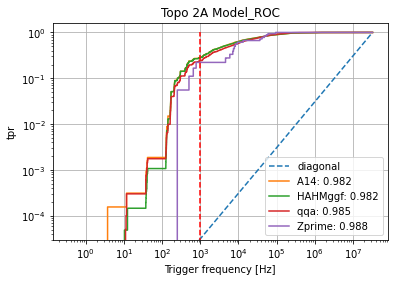


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14: 28.3365%, Theshold = 1.461149
HAHMggf: 28.2593%, Theshold = 1.461149
qqa: 24.1051%, Theshold = 1.461149
Zprime: 22.2222%, Theshold = 1.461149


In [60]:
#Topo 2A Analyses

Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_6/',
                               Topo_2A_L1failed,
                               Topo_EB_L1failed_weights,
                               [Topo_2A_A14_pure,
                                    Topo_2A_HAHMggf_pure,
                                    Topo_2A_qqa_pure,
                                    Topo_2A_Zprime_pure],
                               [np.ones(len(Topo_2A_A14_pure)),
                                    np.ones(len(Topo_2A_HAHMggf_pure)),
                                    np.ones(len(Topo_2A_qqa_pure)),
                                    np.ones(len(Topo_2A_Zprime_pure))],
                               input_dim = Topo_2A_test_br.shape[1],
                               title='Topo 2A Model',
                               save = False,
                               labels = ['A14',
                                             'HAHMggf',
                                             'qqa',
                                             'Zprime'])
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_0/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285

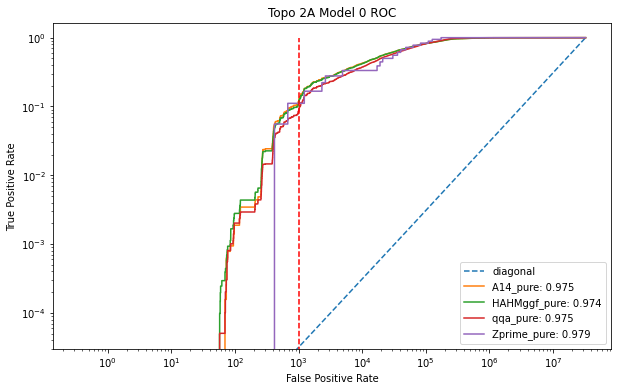


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 11.669799%
HAHMggf_pure: 11.126353%
qqa_pure: 8.470304%
Zprime_pure: 11.111111%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.11669799498746868), ('HAHMggf_pure', 0.11126353436872274), ('qqa_pure', 0.08470303519209438), ('Zprime_pure', 0.1111111111111111)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_1/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (3

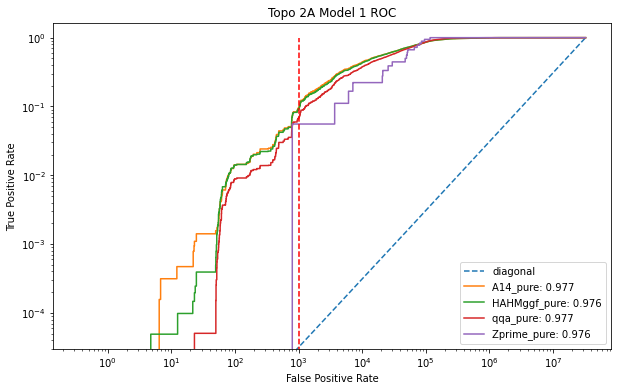


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 9.586466%
HAHMggf_pure: 9.181324%
qqa_pure: 6.786327%
Zprime_pure: 5.555556%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.09586466165413533), ('HAHMggf_pure', 0.09181323795992358), ('qqa_pure', 0.06786326510033276), ('Zprime_pure', 0.05555555555555555)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_2/


Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 20ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285420,)
Successfully processed batch 3


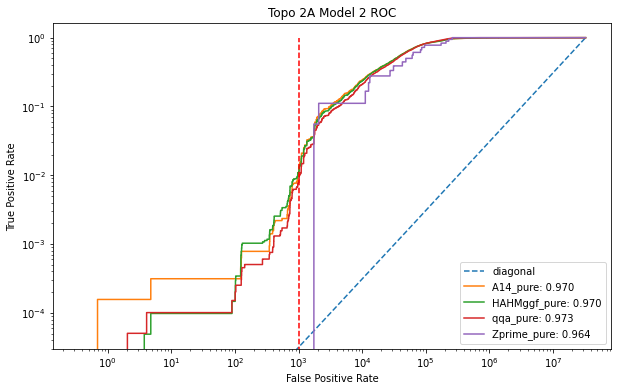


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 1.096491%
HAHMggf_pure: 1.097447%
qqa_pure: 0.781486%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.010964912280701754), ('HAHMggf_pure', 0.010974474548037823), ('qqa_pure', 0.007814863365937279), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_3/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Success

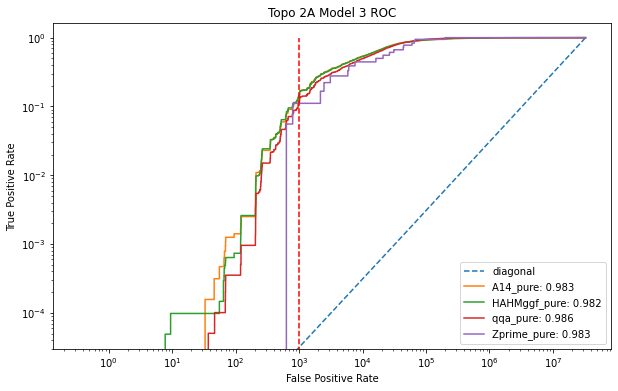


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 14.113409%
HAHMggf_pure: 14.335407%
qqa_pure: 11.379449%
Zprime_pure: 11.111111%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.14113408521303258), ('HAHMggf_pure', 0.14335407378374407), ('qqa_pure', 0.11379449430271252), ('Zprime_pure', 0.1111111111111111)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_4/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (

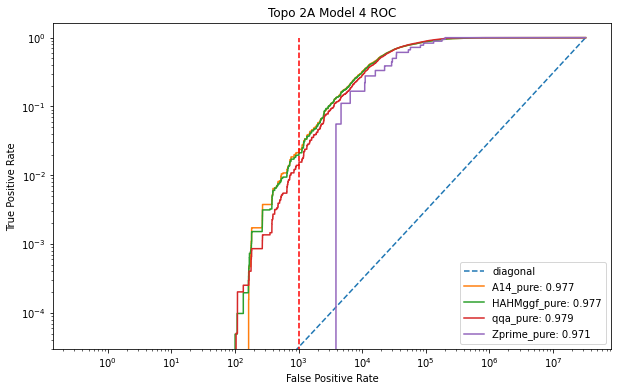


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 2.130326%
HAHMggf_pure: 1.954828%
qqa_pure: 1.391550%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.021303258145363407), ('HAHMggf_pure', 0.019548282788692372), ('qqa_pure', 0.01391549863870122), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_5/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 20ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successf

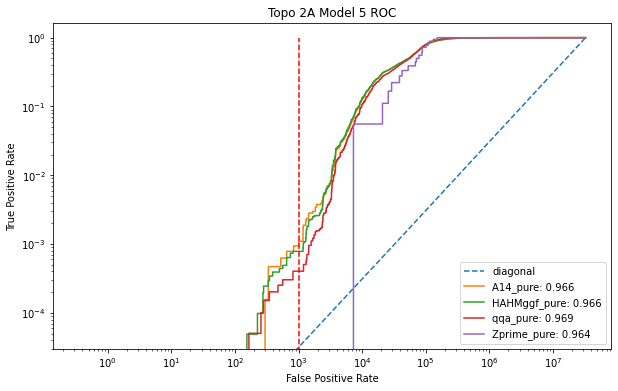


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 0.093985%
HAHMggf_pure: 0.078389%
qqa_pure: 0.040335%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.0009398496240601503), ('HAHMggf_pure', 0.0007838910391455587), ('qqa_pure', 0.0004033477866290209), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_6/


Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285420,)
Successfully processed batch 3


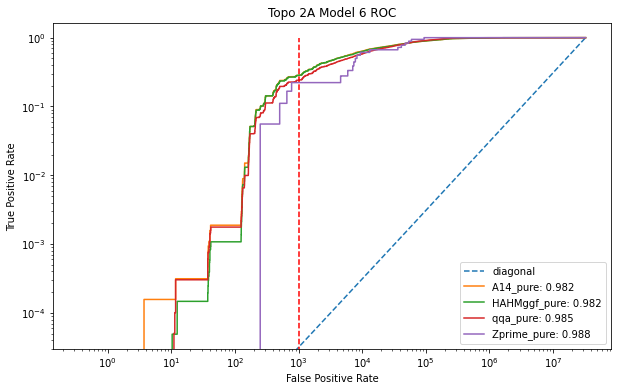


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 28.336466%
HAHMggf_pure: 28.259272%
qqa_pure: 24.105072%
Zprime_pure: 22.222222%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.2833646616541353), ('HAHMggf_pure', 0.2825927196119739), ('qqa_pure', 0.2410507209841686), ('Zprime_pure', 0.2222222222222222)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_7/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 23ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305

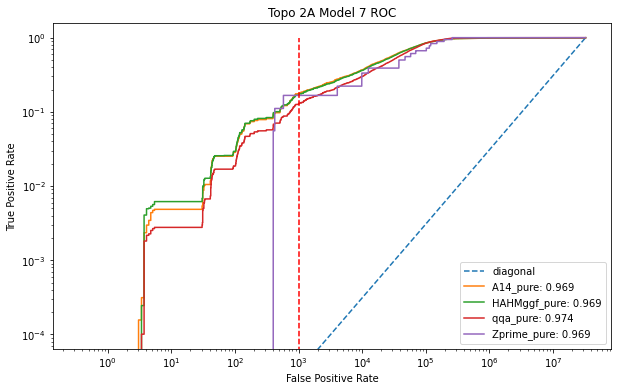


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 17.575188%
HAHMggf_pure: 16.829161%
qqa_pure: 12.660079%
Zprime_pure: 16.666667%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.17575187969924813), ('HAHMggf_pure', 0.16829160746656216), ('qqa_pure', 0.12660078652818393), ('Zprime_pure', 0.16666666666666666)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_8/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: 

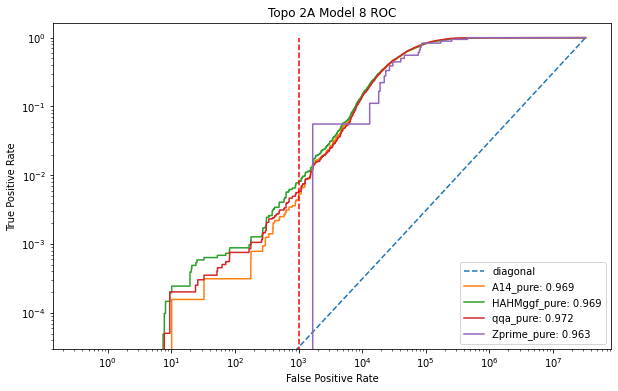


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 0.454261%
HAHMggf_pure: 0.788790%
qqa_pure: 0.569729%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.0045426065162907266), ('HAHMggf_pure', 0.007887903581402185), ('qqa_pure', 0.00569728748613492), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_9/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 20ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Success

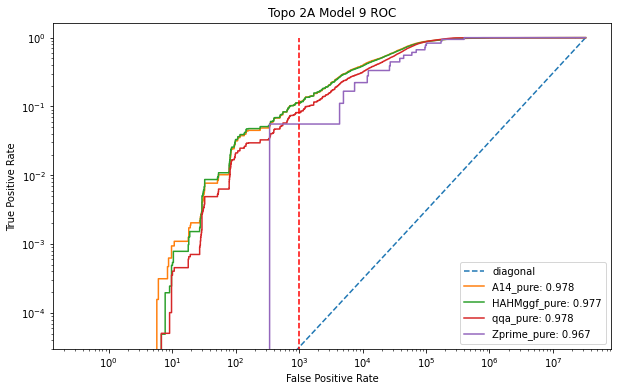


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 11.293860%
HAHMggf_pure: 11.278232%
qqa_pure: 8.142583%
Zprime_pure: 5.555556%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.11293859649122807), ('HAHMggf_pure', 0.11278232325706727), ('qqa_pure', 0.08142583442573359), ('Zprime_pure', 0.05555555555555555)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_10/
Model_Evaluator instance created successfully
Calculating losses...


1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285420,)
Successfully processed batch 3


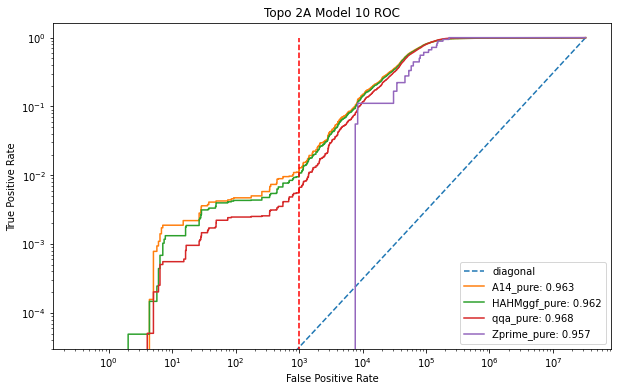


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 1.174812%
HAHMggf_pure: 1.009260%
qqa_pure: 0.615105%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.011748120300751879), ('HAHMggf_pure', 0.010092597128999068), ('qqa_pure', 0.006151053746092568), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_11/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Succes

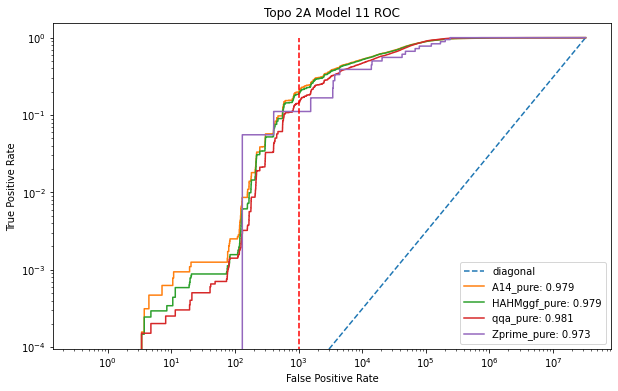


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 19.752506%
HAHMggf_pure: 18.475332%
qqa_pure: 14.071796%
Zprime_pure: 11.111111%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.1975250626566416), ('HAHMggf_pure', 0.18475331928861888), ('qqa_pure', 0.14071795906019965), ('Zprime_pure', 0.1111111111111111)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_12/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (

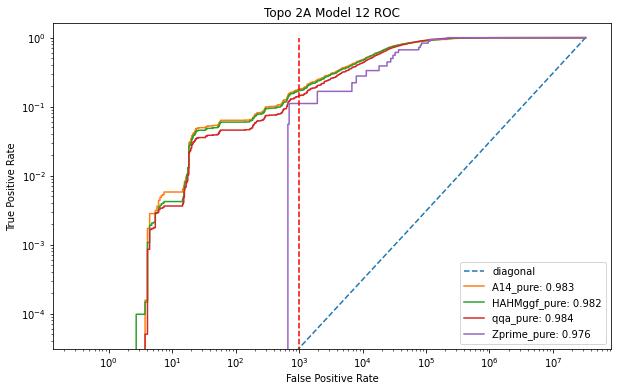


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 17.998120%
HAHMggf_pure: 17.137818%
qqa_pure: 14.490269%
Zprime_pure: 11.111111%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.1799812030075188), ('HAHMggf_pure', 0.17137817843319778), ('qqa_pure', 0.14490269234647574), ('Zprime_pure', 0.1111111111111111)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_13/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 20ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (

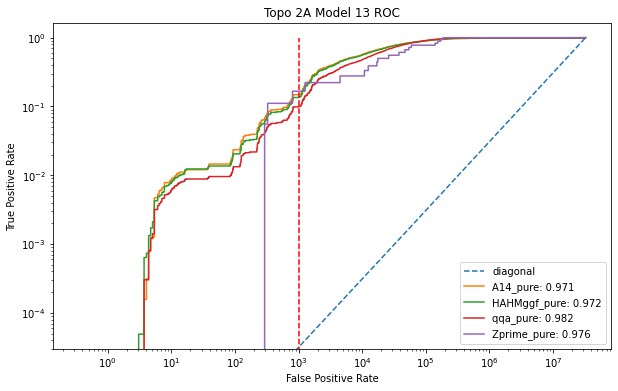


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 14.833960%
HAHMggf_pure: 13.497624%
qqa_pure: 9.871937%
Zprime_pure: 16.666667%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.14833959899749374), ('HAHMggf_pure', 0.1349762383028759), ('qqa_pure', 0.09871937077745285), ('Zprime_pure', 0.16666666666666666)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_14/
Model_Evaluator instance created successfully
Calculating losses...


1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285420,)
Successfully processed batch 3


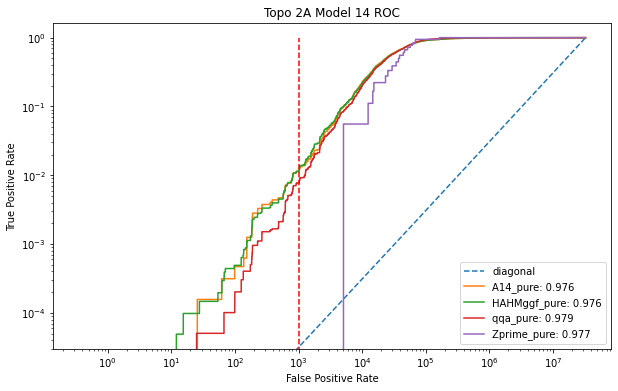


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 1.127820%
HAHMggf_pure: 1.146441%
qqa_pure: 0.771403%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.011278195488721804), ('HAHMggf_pure', 0.011464406447503798), ('qqa_pure', 0.0077140264192800245), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_15/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Succe

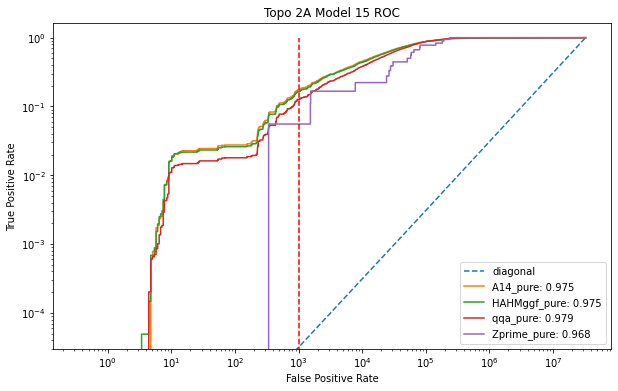


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 17.402882%
HAHMggf_pure: 16.574396%
qqa_pure: 12.675204%
Zprime_pure: 5.555556%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.17402882205513784), ('HAHMggf_pure', 0.16574396158933907), ('qqa_pure', 0.1267520419481698), ('Zprime_pure', 0.05555555555555555)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_16/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (

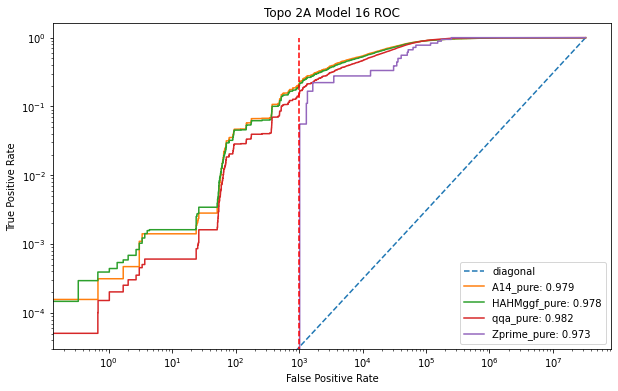


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 20.958647%
HAHMggf_pure: 19.460095%
qqa_pure: 14.676818%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.20958646616541354), ('HAHMggf_pure', 0.19460095046788498), ('qqa_pure', 0.14676817585963498), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_17/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Succes

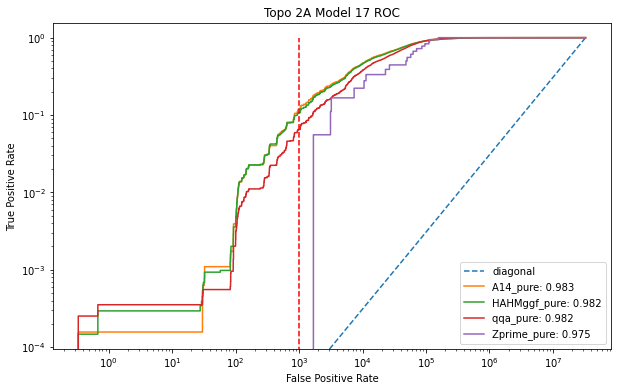


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 11.732456%
HAHMggf_pure: 10.700113%
qqa_pure: 6.483816%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.11732456140350878), ('HAHMggf_pure', 0.10700112684336877), ('qqa_pure', 0.0648381567006151), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_18/
Model_Evaluator instance created successfully
Calculating losses...


1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285420,)
Successfully processed batch 3


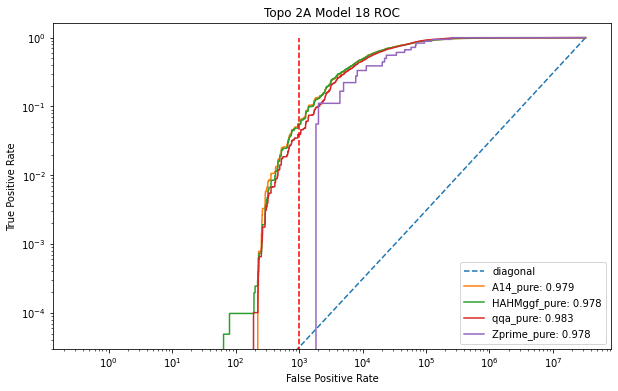


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 5.623434%
HAHMggf_pure: 5.438244%
qqa_pure: 3.872139%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.056234335839599), ('HAHMggf_pure', 0.05438244084072314), ('qqa_pure', 0.038721387516386006), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_19/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 23ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successful

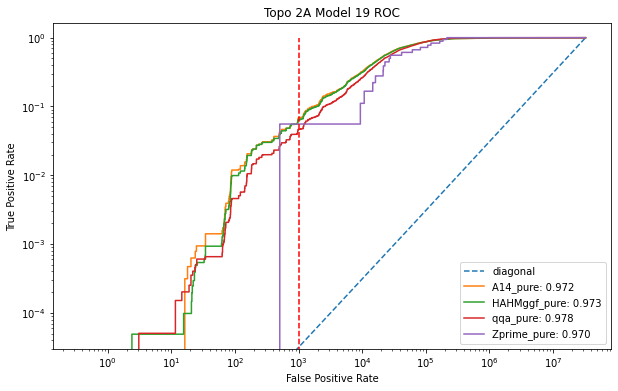


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 6.813910%
HAHMggf_pure: 6.413209%
qqa_pure: 4.643541%
Zprime_pure: 5.555556%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.0681390977443609), ('HAHMggf_pure', 0.06413208564009602), ('qqa_pure', 0.046435413935666026), ('Zprime_pure', 0.05555555555555555)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_20/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (30

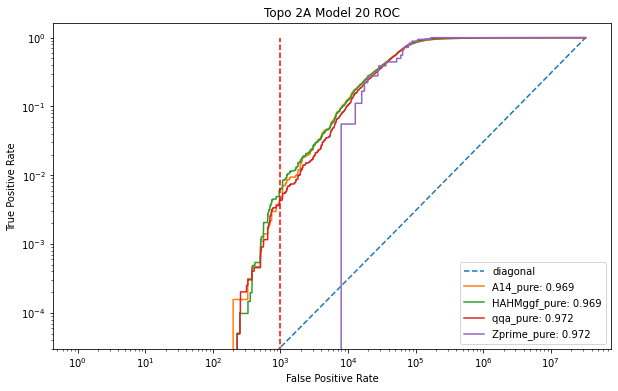


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 0.469925%
HAHMggf_pure: 0.632012%
qqa_pure: 0.433599%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.004699248120300752), ('HAHMggf_pure', 0.006320121503111067), ('qqa_pure', 0.004335988706261974), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_21/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Succes

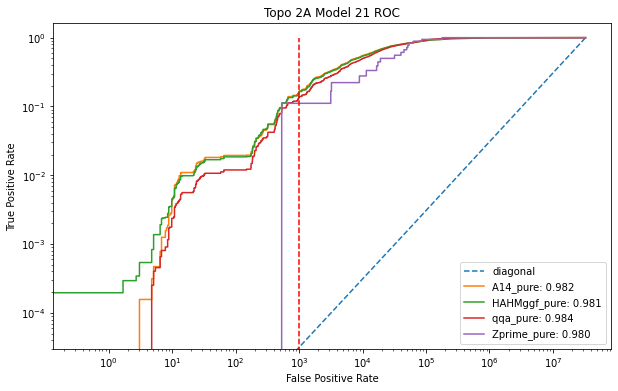


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 16.353383%
HAHMggf_pure: 16.001176%
qqa_pure: 13.597862%
Zprime_pure: 11.111111%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.16353383458646617), ('HAHMggf_pure', 0.16001175836558718), ('qqa_pure', 0.13597862256730867), ('Zprime_pure', 0.1111111111111111)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_22/
Model_Evaluator instance created successfully
Calculating losses...


1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285420,)
Successfully processed batch 3


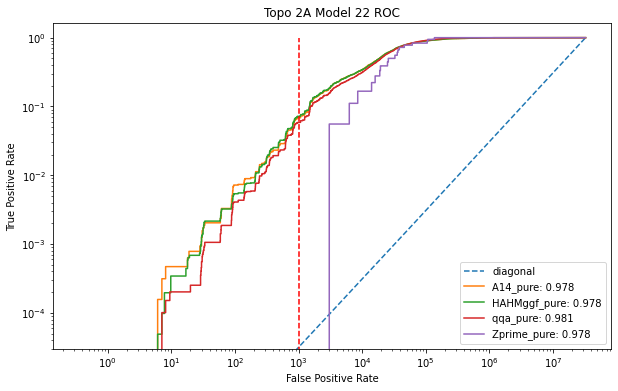


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 6.829574%
HAHMggf_pure: 7.187301%
qqa_pure: 5.853585%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.06829573934837092), ('HAHMggf_pure', 0.07187300965165842), ('qqa_pure', 0.05853584753453665), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_23/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfu

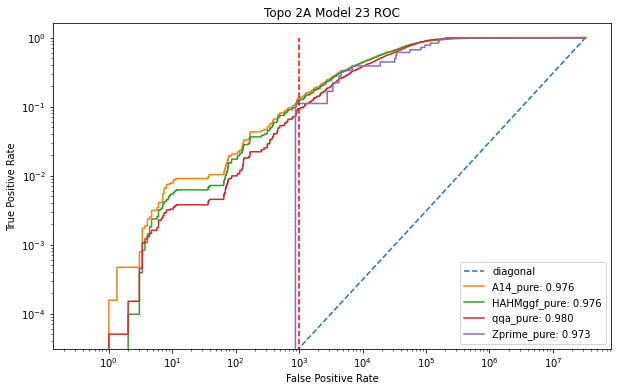


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 13.204887%
HAHMggf_pure: 12.365881%
qqa_pure: 9.337501%
Zprime_pure: 11.111111%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.13204887218045114), ('HAHMggf_pure', 0.1236588114252119), ('qqa_pure', 0.09337501260461833), ('Zprime_pure', 0.1111111111111111)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_24/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (3

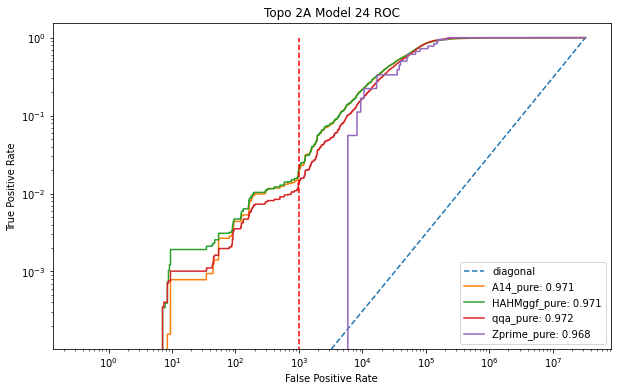


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 1.926692%
HAHMggf_pure: 2.106707%
qqa_pure: 1.401634%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.01926691729323308), ('HAHMggf_pure', 0.02106707167703689), ('qqa_pure', 0.014016335585358475), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_25/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successf

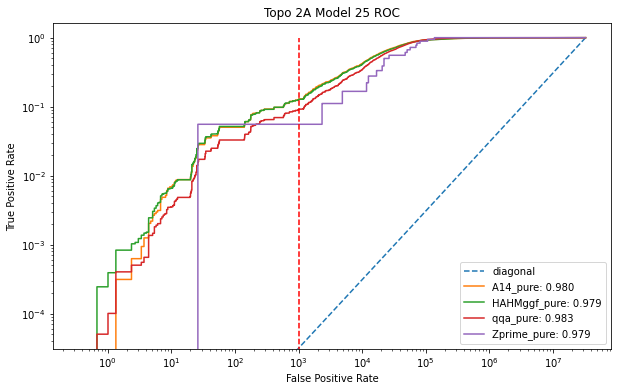


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 12.656642%
HAHMggf_pure: 12.552055%
qqa_pure: 9.024907%
Zprime_pure: 5.555556%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.12656641604010024), ('HAHMggf_pure', 0.1255205526431826), ('qqa_pure', 0.09024906725824342), ('Zprime_pure', 0.05555555555555555)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_26/
Model_Evaluator instance created successfully
Calculating losses...


1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfully processed batch 1
Processing batch 2
Batch length: 19834
Signal weight length: 19834
ROC_data shape: (305236,)
truth shape: (305236,)
weights shape: (305236,)
Successfully processed batch 2
Processing batch 3
Batch length: 18
Signal weight length: 18
ROC_data shape: (285420,)
truth shape: (285420,)
weights shape: (285420,)
Successfully processed batch 3


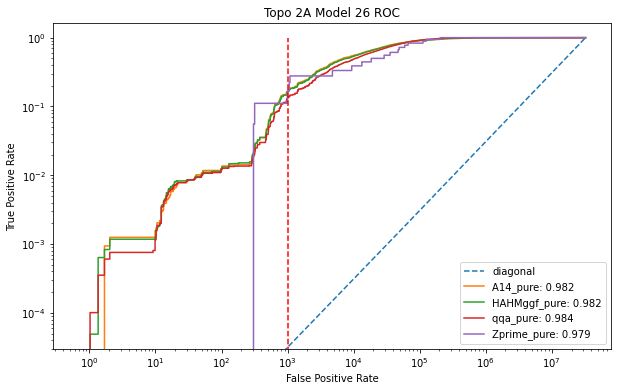


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 16.572682%
HAHMggf_pure: 16.202048%
qqa_pure: 13.073510%
Zprime_pure: 16.666667%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.16572681704260653), ('HAHMggf_pure', 0.16202047915339768), ('qqa_pure', 0.1307351013411314), ('Zprime_pure', 0.16666666666666666)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_27/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: 

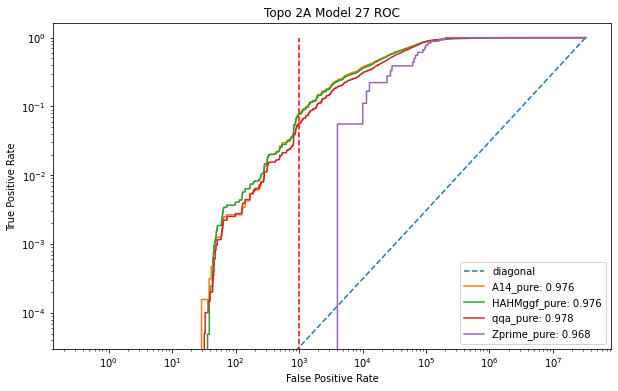


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 7.800752%
HAHMggf_pure: 7.672334%
qqa_pure: 5.712413%
Zprime_pure: 0.000000%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.07800751879699248), ('HAHMggf_pure', 0.07672333545637157), ('qqa_pure', 0.05712413028133508), ('Zprime_pure', 0.0)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_28/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 21ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape: (305813,)
Successfu

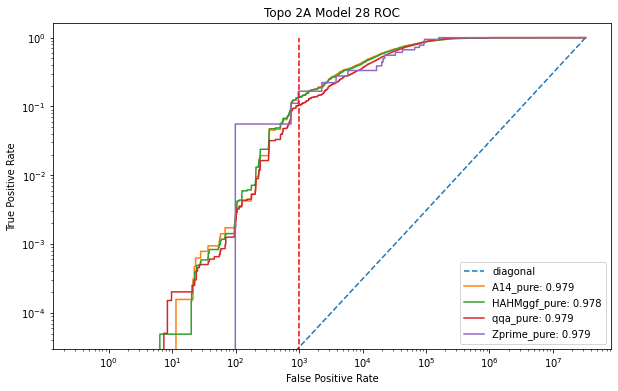


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 13.565163%
HAHMggf_pure: 13.615207%
qqa_pure: 10.466875%
Zprime_pure: 16.666667%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.13565162907268172), ('HAHMggf_pure', 0.13615207486159425), ('qqa_pure', 0.10466875063023091), ('Zprime_pure', 0.16666666666666666)]
Evaluating model from path: /eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_29/
Model_Evaluator instance created successfully
Calculating losses...
1/1 [==============================] - 0s 22ms/step
Losses calculated
Getting performance...
Number of signal losses: 4
Number of labels: 4
Number of signal weights: 4
Length of br_loss: 285402
Processing batch 0
Batch length: 6384
Signal weight length: 6384
ROC_data shape: (291786,)
truth shape: (291786,)
weights shape: (291786,)
Successfully processed batch 0
Processing batch 1
Batch length: 20411
Signal weight length: 20411
ROC_data shape: (305813,)
truth shape: (305813,)
weights shape:

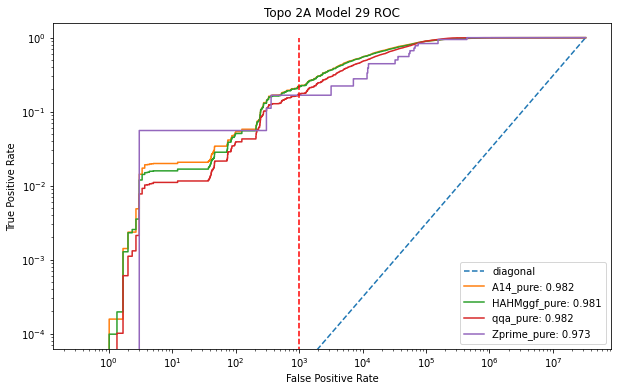


TPR at FPR = 3.0658509751158016e-05 for each channel:
A14_pure: 21.898496%
HAHMggf_pure: 21.601097%
qqa_pure: 17.001109%
Zprime_pure: 16.666667%
Number of results: 4
GetPerformance() returned: [('A14_pure', 0.21898496240601503), ('HAHMggf_pure', 0.21601097447454803), ('qqa_pure', 0.17001109206413229), ('Zprime_pure', 0.16666666666666666)]
Final channel results: {'A14_pure': [0.11669799498746868, 0.09586466165413533, 0.010964912280701754, 0.14113408521303258, 0.021303258145363407, 0.0009398496240601503, 0.2833646616541353, 0.17575187969924813, 0.0045426065162907266, 0.11293859649122807, 0.011748120300751879, 0.1975250626566416, 0.1799812030075188, 0.14833959899749374, 0.011278195488721804, 0.17402882205513784, 0.20958646616541354, 0.11732456140350878, 0.056234335839599, 0.0681390977443609, 0.004699248120300752, 0.16353383458646617, 0.06829573934837092, 0.13204887218045114, 0.01926691729323308, 0.12656641604010024, 0.16572681704260653, 0.07800751879699248, 0.13565162907268172, 0.2189849

In [57]:
results = []
signal_names = ['A14', 'HAHMggf', 'qqa', 'Zprime']
channel_results = {}
for i in range(30):
    try:
        model_path = f'/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_{i}/'
        print(f"Evaluating model from path: {model_path}")
        
        evaluation = Model_Evaluator(model_path,
                                   Topo_2A_L1failed,
                                   Topo_EB_L1failed_weights,
                                   [Topo_2A_A14_pure,
                                        Topo_2A_HAHMggf_pure,
                                        Topo_2A_qqa_pure,
                                        Topo_2A_Zprime_pure],
                                   [np.ones(len(Topo_2A_A14_pure)),
                                        np.ones(len(Topo_2A_HAHMggf_pure)),
                                        np.ones(len(Topo_2A_qqa_pure)),
                                        np.ones(len(Topo_2A_Zprime_pure))],
                                   input_dim = 44,
                                   title=f'Topo 2A Model {i}',
                                   save = False,
                                   labels = ['A14_pure',
                                                 'HAHMggf_pure',
                                                 'qqa_pure',
                                                 'Zprime_pure'])
        
        print("Model_Evaluator instance created successfully")
        
        print("Calculating losses...")
        evaluation.calculate_loss('CKL')
        print("Losses calculated")
        
        print("Getting performance...")
        result = evaluation.GetPerformance()
        print(f"GetPerformance() returned: {result}")
        
        if not result:
            print(f"Warning: GetPerformance() returned an empty result for model {i}")
        else:
            for channel, tpr in result:
                if channel not in channel_results:
                    channel_results[channel] = []
                channel_results[channel].append(tpr)
    
    except Exception as e:
        print(f"An error occurred while evaluating model {i}:")
        print(traceback.format_exc())

print("Final channel results:", channel_results)

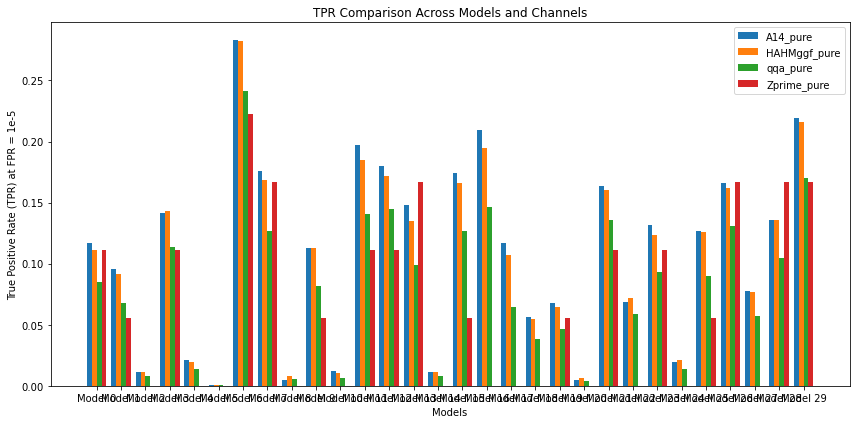


Channel Statistics:
A14_pure: Mean TPR = 0.1083, Std Dev = 0.0752
HAHMggf_pure: Mean TPR = 0.1049, Std Dev = 0.0726
qqa_pure: Mean TPR = 0.0808, Std Dev = 0.0592
Zprime_pure: Mean TPR = 0.0667, Std Dev = 0.0694


In [58]:
if channel_results:
    plt.figure(figsize=(12, 6))
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    x = np.arange(n_models)
    width = 0.8 / n_channels
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.bar(x + i * width, tprs, width, label=channel)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
    plt.legend()
    plt.tight_layout()
    plt.savefig('tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

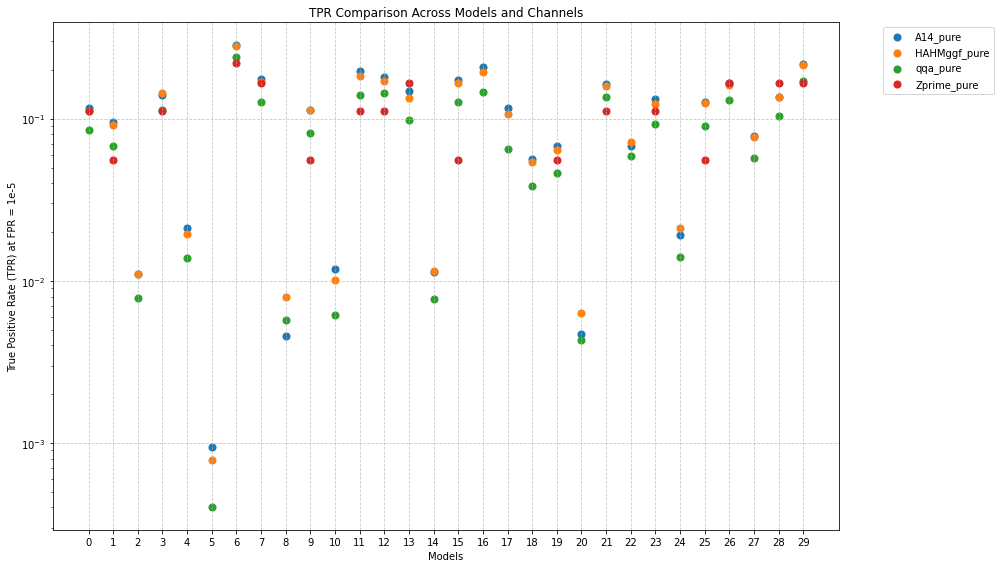


Channel Statistics:
A14_pure: Mean TPR = 0.1083, Std Dev = 0.0752
HAHMggf_pure: Mean TPR = 0.1049, Std Dev = 0.0726
qqa_pure: Mean TPR = 0.0808, Std Dev = 0.0592
Zprime_pure: Mean TPR = 0.0667, Std Dev = 0.0694


In [59]:
if channel_results:
    plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.scatter(range(n_models), tprs, label=channel, s=50)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.semilogy()
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('tpr_comparison_plot.png', dpi=600, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

In [ ]:
#Topo 2A Analyses

Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/version9/',
                               Topo_2A_test_br,
                               Topo_br_weights,
                               [Topo_2A_test_signal,
                                    Topo_2A_HLT_passed,
                                    Topo_2A_L1_passed,
                                    Topo_2A_HHbbtt,
                                    Topo_2A_jz1,
                                    Topo_2A_jz2,
                                    Topo_2A_jz4,
                                    Topo_2A_A14,
                                    Topo_2A_HAHMggf,
                                    Topo_2A_qqa,
                                    Topo_2A_Zprime,
                                    Topo_2A_ZZ4lep],
                               [Topo_signal_weights,
                                    Topo_HLT_weights,
                                    Topo_L1_weights,
                                    np.ones(len(Topo_2A_HHbbtt)),
                                    np.ones(len(Topo_2A_jz1)),
                                    np.ones(len(Topo_2A_jz2)),
                                    np.ones(len(Topo_2A_jz4)),
                                    np.ones(len(Topo_2A_A14)),
                                    np.ones(len(Topo_2A_HAHMggf)),
                                    np.ones(len(Topo_2A_qqa)),
                                    np.ones(len(Topo_2A_Zprime)),
                                    np.ones(len(Topo_2A_ZZ4lep))],
                               input_dim = Topo_2A_test_br.shape[1],
                               title='Topo 2A Model',
                               save = False,
                               labels = ['backround',
                                             'HLT_passed',
                                             'L1_passed',
                                             'HHbbtt',
                                             'JZ1',
                                             'JZ2',
                                             'JZ4',
                                             'A14',
                                             'HAHMggf',
                                             'qqa',
                                             'Zprime',
                                             'ZZ4lep'])
#     A2_MSE=evaluation.calculate_loss('MSE')[0]
    A2_loss=evaluation.calculate_loss(string)[1][0]
    evaluation.ROC()

In [2]:
def plot_distribution_outside(br_loss, br_weights, signal_losses, signal_weights, labels, 
                                    title, saveplots=False, save_path=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    bins = 100
    
    # Determine the range for the bins
    all_scores = np.concatenate([br_loss] + signal_losses)
    min_score, max_score = 0.1, 1e2
    bin_edges = np.linspace(min_score, max_score, bins + 1)

    # Plot signal distributions
    colors = plt.cm.rainbow(np.linspace(0, 1, len(signal_losses)))
    for i, (signal_scores, signal_weights, label) in enumerate(zip(signal_losses, signal_weights, labels)):
        signal_weights = signal_weights / np.sum(signal_weights)  # Normalize weights
        ax.hist(signal_scores, bins=bin_edges, weights=signal_weights, 
                histtype='step', label=label, color=colors[i],
                density=True, linewidth=2)
    
    # Plot background distribution
    br_weights = br_weights / np.sum(br_weights)  # Normalize weights
    ax.hist(br_loss, bins=bin_edges, weights=br_weights, histtype='step', 
            label='Background', color='black', density=True, linewidth=2)
    
    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Weighted Normalized Density')
    ax.set_title(f'{title} Weighted Normalized Anomaly Score Distribution')
    ax.legend()
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    ax.set_ylim(bottom=1e-5, top=10)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if saveplots and save_path:
        plt.savefig(save_path, format="png", bbox_inches="tight")
    plt.show()


In [4]:
#2A_unweighted
# Losses=['CKL']
# for string in Losses:
#     evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/version2/',
#                                Topo_2A_test_br,
#                                np.ones(len(Topo_2A_test_br)),
#                                [Topo_2A_test_signal,
#                                     Topo_2A_HLT_passed,
#                                     Topo_2A_L1_passed,
#                                     Topo_2A_HHbbtt,
#                                     Topo_2A_jz2,
#                                     Topo_2A_jz4,
#                                     Topo_2A_A14,
#                                     Topo_2A_HAHMggf,
#                                     Topo_2A_qqa,
#                                     Topo_2A_Zprime,
#                                     Topo_2A_ZZ4lep],
#                                [np.ones(len(Topo_2A_test_signal)),
#                                     np.ones(len(Topo_2A_HLT_passed)),
#                                     np.ones(len(Topo_2A_L1_passed)),
#                                     np.ones(len(Topo_2A_HHbbtt)),
#                                     np.ones(len(Topo_2A_jz2)),
#                                     np.ones(len(Topo_2A_jz4)),
#                                     np.ones(len(Topo_2A_A14)),
#                                     np.ones(len(Topo_2A_HAHMggf)),
#                                     np.ones(len(Topo_2A_qqa)),
#                                     np.ones(len(Topo_2A_Zprime)),
#                                     np.ones(len(Topo_2A_ZZ4lep))],
#                                input_dim = Topo_2A_test_br.shape[1],
#                                title='Topo 2A Model',
#                                save = False,
#                                labels = ['backround',
#                                              'HLT_passed',
#                                              'L1_passed',
#                                              'HHbbtt',
#                                              'JZ2',
#                                              'JZ4',
#                                              'A14',
#                                              'HAHMggf',
#                                              'qqa',
#                                              'Zprime',
#                                              'ZZ4lep'])    #A2_MSE=evaluation.calculate_loss('MSE')[0]
#     A2_loss=evaluation.calculate_loss(string)[1][0]
#     evaluation.ROC()

In [ ]:
#Topo 2B Analyses

Losses=['CKL']
for string in Losses:
    #evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_2B/Topo_2B_Version_1/',Topo_2B_test_br,Topo_br_weights,[Topo_2B_test_signal,Topo_2B_HLT_passed,Topo_2B_L1_passed,Topo_2B_just_L1_passed,Topo_2B_HHbbtt,Topo_2B_HHbbtt_unpassed,Topo_2B_jz2,Topo_2B_jz4],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],Topo_signal_weights[L1_pass_test==1][HLT_pass_test[L1_pass_test==1]==0],np.ones(len(Topo_2B_HHbbtt)),np.ones(len(Topo_2B_HHbbtt_unpassed)),np.ones(len(Topo_2B_jz2)),np.ones(len(Topo_2B_jz4))],input_dim=75,title='Topo 2B Model', save=False,labels=['backround','HLT_passed','L1_passed','just_L1_passed','HHbb','HHbb Undetected','JZ2','JZ4'])
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2B/version3/',
                               Topo_2B_test_br,
                               Topo_br_weights,
                               [Topo_2B_test_signal,
                                    Topo_2B_HLT_passed,
                                    Topo_2B_L1_passed,
                                    Topo_2B_HHbbtt,
                                    Topo_2B_jz1,
                                    Topo_2B_jz2,
                                    Topo_2B_jz4,
                                    Topo_2B_A14,
                                    Topo_2B_HAHMggf,
                                    Topo_2B_qqa,
                                    Topo_2B_Zprime,
                                    Topo_2B_ZZ4lep],
                               [Topo_signal_weights,
                                    Topo_signal_weights[HLT_pass_test==1],
                                    Topo_signal_weights[L1_pass_test==1],
                                    np.ones(len(Topo_2B_HHbbtt)),
                                    np.ones(len(Topo_2B_jz1)),
                                    np.ones(len(Topo_2B_jz2)),
                                    np.ones(len(Topo_2B_jz4)),
                                    np.ones(len(Topo_2B_A14)),
                                    np.ones(len(Topo_2B_HAHMggf)),
                                    np.ones(len(Topo_2B_qqa)),
                                    np.ones(len(Topo_2B_Zprime)),
                                    np.ones(len(Topo_2B_ZZ4lep))],
                               input_dim = Topo_2B_test_br.shape[1],
                               title='Topo 2B Model',
                               save = False,
                               labels = ['backround',
                                             'HLT_passed',
                                             'L1_passed',
                                             'HHbbtt',
                                             'JZ1',
                                             'JZ2',
                                             'JZ4',
                                             'A14',
                                             'HAHMggf',
                                             'qqa',
                                             'Zprime',
                                             'ZZ4lep'])
    B2_MSE=evaluation.calculate_loss('MSE')[0]
    B2_loss=evaluation.calculate_loss(string)[1][0]
    #B2_triggered=evaluation.event_anomally_checker(10**-5)
    #evaluation.Sensitivity()
    #evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()
    #evaluation.Plot_2D()
    #evaluation.pt_correlation()

In [ ]:
#Topo 3A Analyses

Losses=['CKL']
for string in Losses:
    #evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/L1_models/Topo_3A/Topo_3A_Version_1/',Topo_3A_test_br,Topo_br_weights,[Topo_3A_test_signal,Topo_3A_HLT_passed,Topo_3A_L1_passed,Topo_3A_just_L1_passed,Topo_3A_HHbbtt,Topo_3A_HHbbtt_unpassed,Topo_3A_jz2,Topo_3A_jz4],[Topo_signal_weights,Topo_signal_weights[HLT_pass_test==1],Topo_signal_weights[L1_pass_test==1],Topo_signal_weights[L1_pass_test==1][HLT_pass_test[L1_pass_test==1]==0],np.ones(len(Topo_3A_HHbbtt)),np.ones(len(Topo_3A_HHbbtt_unpassed)),np.ones(len(Topo_3A_jz2)),np.ones(len(Topo_3A_jz4))],input_dim=93,title='Topo 3A Model', save=True,labels=['backround','HLT_passed','L1_passed','just_L1_passed','HHbb','HHbb undetected','JZ2','JZ4'])
    evaluation=Model_Evaluator('/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_3A/version5/',
                               Topo_3A_test_br,
                               Topo_br_weights,
                               [Topo_3A_test_signal,
                                    Topo_3A_HLT_passed,
                                    Topo_3A_L1_passed,
                                    Topo_3A_HHbbtt,
                                    Topo_3A_jz1,
                                    Topo_3A_jz2,
                                    Topo_3A_jz4,
                                    Topo_3A_A14,
                                    Topo_3A_HAHMggf,
                                    Topo_3A_qqa,
                                    Topo_3A_Zprime,
                                    Topo_3A_ZZ4lep],
                               [Topo_signal_weights,
                                    Topo_signal_weights[HLT_pass_test==1],
                                    Topo_signal_weights[L1_pass_test==1],
                                    np.ones(len(Topo_3A_HHbbtt)),
                                    np.ones(len(Topo_3A_jz1)),
                                    np.ones(len(Topo_3A_jz2)),
                                    np.ones(len(Topo_3A_jz4)),
                                    np.ones(len(Topo_3A_A14)),
                                    np.ones(len(Topo_3A_HAHMggf)),
                                    np.ones(len(Topo_3A_qqa)),
                                    np.ones(len(Topo_3A_Zprime)),
                                    np.ones(len(Topo_3A_ZZ4lep))],
                               input_dim = Topo_3A_test_br.shape[1],
                               title='Topo 3A Model',
                               save = False,
                               labels = ['backround',
                                             'HLT_passed',
                                             'L1_passed',
                                             'HHbbtt',
                                             'JZ1',
                                             'JZ2',
                                             'JZ4',
                                             'A14',
                                             'HAHMggf',
                                             'qqa',
                                             'Zprime',
                                             'ZZ4lep'])
    A3_MSE=evaluation.calculate_loss('MSE')[0]
    A3_loss=evaluation.calculate_loss(string)[1][0]
    #A3_triggered=evaluation.event_anomally_checker(10**-5)
    #evaluation.Sensitivity()
    #evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()
    #evaluation.Plot_2D()
    #evaluation.pt_correlation()

In [61]:
# ori_vae_enc = Qmake_encoder_set_weights(Topo_2A_test_br.shape[1],32,16,3)
# ori_vae_dec = Qmake_decoder_set_weights(Topo_2A_test_br.shape[1],32,16,3)
ori_vae_enc = Qmake_encoder_set_weights(44,32,16,3)
ori_vae_dec = Qmake_decoder_set_weights(44,32,16,3)
orginal_model = VAE_Model(ori_vae_enc, ori_vae_dec)

orginal_model.load_weights("/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_FDL_6/")
#orginal_model.load_weights("/eos/user/h/hjia/AnomalyDetection/trained_models/L1_models/Topo_2A/version9/")
# def make_simplified_encoder(input_dim, h_dim_1, h_dim_2, latent_dim):
#     inputs = keras.Input(shape=(input_dim,), name='inputs')
#     x = Dense(h_dim_1, name = "dense1")(inputs)
#     x = ReLU(name = 'relu1')(x)
#     x = Dense(h_dim_2, name = "dense2")(x)
#     x = ReLU(name = 'relu2')(x)
#     z_mean = Dense(latent_dim, name='z_mean',)(x)
#     new_encoder = keras.Model(inputs, z_mean, name='simplified_encoder')
#     return new_encoder
def make_simplified_encoder(input_dim, h_dim_1, h_dim_2, latent_dim):
    inputs = keras.Input(shape=(input_dim,), name='inputs')
    x = QDense(h_dim_1,
            kernel_quantizer=quantized_bits(10,5,0,alpha=1),
            bias_quantizer=quantized_bits(10,5,0,alpha=1),
            name = "dense1")(inputs)
    x = QBatchNormalization(name="BN1")(x)
    x = QActivation(quantized_relu(15, negative_slope=1/1024), name = 'relu1')(x)
    x = QDense(h_dim_2,
            kernel_quantizer=quantized_bits(10,5,0,alpha=1),
            bias_quantizer=quantized_bits(10,5,0,alpha=1),
            name = "dense2")(x)
    x = QBatchNormalization(name="BN2")(x)
    x = QActivation(quantized_relu(15, negative_slope=1/1024), name = 'relu2')(x)
    z_mean = QDense(latent_dim, name='z_mean',
                  kernel_quantizer=quantized_bits(10,5,0,alpha=1),
                  bias_quantizer=quantized_bits(10,5,0,alpha=1))(x)
    new_encoder = keras.Model(inputs, z_mean, name='simplified_encoder')
    return new_encoder

In [62]:
# Create the new encoder
# new_encoder = make_simplified_encoder(Topo_2A_test_br.shape[1],32,16,3)
new_encoder = make_simplified_encoder(44,32,16,3)
# Transfer weights from the original encoder
for layer in new_encoder.layers:
    original_layer = ori_vae_enc.get_layer(layer.name)
    if original_layer is not None:
        print("set weight for ", layer)
        print(original_layer.get_weights())
        layer.set_weights(original_layer.get_weights())

set weight for  <keras.src.engine.input_layer.InputLayer object at 0x7fc5fcd9ad30>
[]
set weight for  <qkeras.qlayers.QDense object at 0x7fc5eae14370>
[array([[ 0.0904367 , -0.0240507 ,  0.0962285 , ..., -0.04425318,
        -0.06783541, -0.38171932],
       [ 0.053365  , -0.00409332,  0.01681035, ...,  0.03325813,
         0.03170431,  0.08185963],
       [ 0.07515104, -0.02947923,  0.01685428, ..., -0.08223964,
         0.02996828,  0.03240955],
       ...,
       [-0.12662487, -0.08388443,  0.03213369, ..., -0.02540464,
         0.01455268,  0.04640013],
       [-0.0291624 , -0.0297721 , -0.02717469, ...,  0.02740477,
        -0.0342765 , -0.01176362],
       [-0.00764854,  0.02657198,  0.03300299, ...,  0.02992635,
         0.01378386,  0.04795142]], dtype=float32), array([-0.15232833, -0.07149181,  0.00471714, -0.16009696,  0.28186056,
        0.0627128 ,  0.09025404, -0.18689057, -0.18266307, -0.14199714,
       -0.07653129, -0.05308229, -0.08972222, -0.16919766, -0.09895647,
   

In [63]:
tf.keras.models.save_model(new_encoder, '2A_AE_model_FDL_BESTOFLONGRUN', save_format='tf')

INFO:tensorflow:Assets written to: 2A_AE_model_FDL_BESTOFLONGRUN/assets


INFO:tensorflow:Assets written to: 2A_AE_model_FDL_BESTOFLONGRUN/assets


620/620 [==============================] - 1s 2ms/step
(19834, 3)


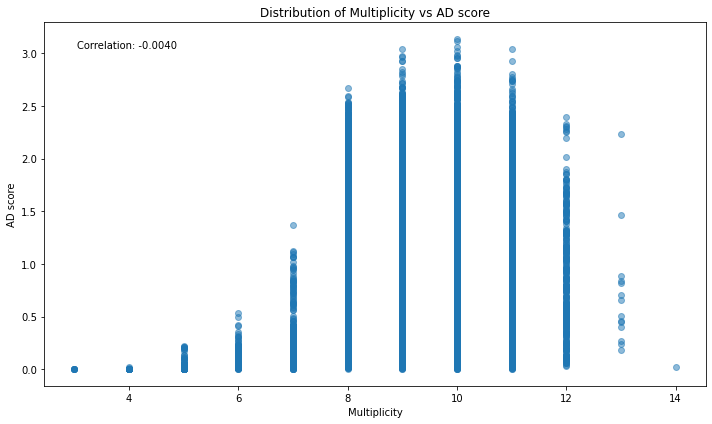

Correlation coefficient: -0.0040


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('2A_AE_model_FDL_BESTOFLONGRUN')
output_data = loaded_model.predict(Topo_2A_qqa_pure)
# output_data = loaded_model.predict(Topo_2A_test_br)
print(output_data.shape)
#first_input = Topo_2A_test_br[:, 0]
first_input = Topo_2A_qqa_pure[:, 0]
columns_of_interest = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42]

# Calculate multiplicity (number of non-zero values) for each row, but only for specified columns
multiplicities = np.count_nonzero(Topo_2A_qqa_pure[:, columns_of_interest], axis=1)

# Calculate the mean of sum of squares of the three outputs
output_mean_sum_squares = np.mean(output_data**2, axis=1)

# Calculate correlation
correlation, _ = pearsonr(multiplicities, output_mean_sum_squares)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(multiplicities, output_mean_sum_squares, alpha=0.5)
plt.xlabel('Multiplicity')
plt.ylabel('AD score')
plt.title('Distribution of Multiplicity vs AD score')

# Add correlation information to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top')

# Show the plot
plt.tight_layout()
plt.show()

print(f"Correlation coefficient: {correlation:.4f}")

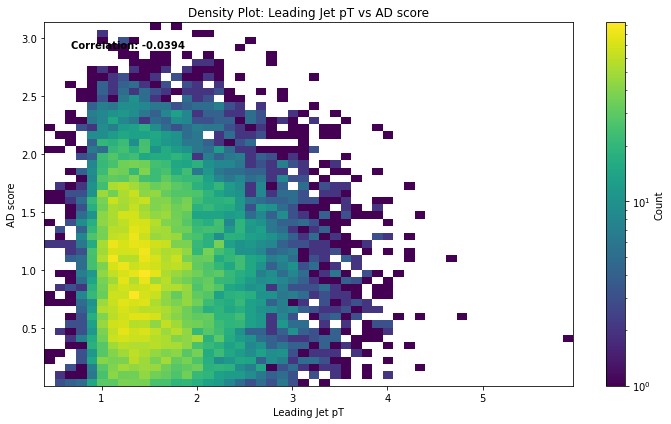

Correlation coefficient: -0.0394


In [25]:
from matplotlib.colors import LogNorm
correlation, _ = pearsonr(first_input, output_mean_sum_squares)

# Create the density plot
plt.figure(figsize=(10, 6))
plt.hist2d(first_input, output_mean_sum_squares, bins=50, cmap='viridis', 
               norm=LogNorm())
plt.colorbar(label='Count')

plt.xlabel('Leading Jet pT')
plt.ylabel('AD score')
plt.title('Density Plot: Leading Jet pT vs AD score')

# Add correlation information to the plot
plt.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
         transform=plt.gca().transAxes, verticalalignment='top', 
         color='black', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

print(f"Correlation coefficient: {correlation:.4f}")

In [ ]:
input_data = Topo_2A_Zprime[9819]

# Ensure the input data has the correct shape
# Add a batch dimension if it's not already present
if input_data.ndim == 1:
    input_data = np.expand_dims(input_data, axis=0)

# Get the second layer of the model (index 1)
second_layer = new_encoder.layers[1]

# Create a new model that goes from the input to the output of the second layer
intermediate_model = tf.keras.Model(inputs=new_encoder.input, outputs=second_layer.output)

# Apply the model up to the second layer to the input
second_layer_output = intermediate_model.predict(input_data)

print("Input shape:", input_data.shape)
print("Second layer output shape:", second_layer_output.shape)
print("Second layer output:")
print(second_layer_output)

# If you want to see the weights of the second layer:
print("\nSecond layer weights:")
print(second_layer.get_weights()[0])  # weights
if len(second_layer.get_weights()) > 1:
    print("\nSecond layer biases:")
    print(second_layer.get_weights()[1])  # biases
else:
    print("\nThis layer does not have separate bias terms.")

In [ ]:
print(len(second_layer.get_weights()[0][0]))

In [ ]:
def print_model_params(model):
    for layer in model.layers:
        if hasattr(layer, 'weights'):
            print(f"Layer: {layer.name}")
            for weight in layer.weights:
                if 'kernel' in weight.name or 'weight' in weight.name:
                    print(f"  Weight - {weight.name}:")
                    print(weight.numpy())
                    print(f"  Shape: {weight.shape}")
                    print()
                elif 'bias' in weight.name:
                    print(f"  Bias - {weight.name}:")
                    print(weight.numpy())
                    print(f"  Shape: {weight.shape}")
                    print()
        else:
            print(f"Layer: {layer.name} (No weights)")
        print("-" * 50)
print_model_params(new_encoder)

In [ ]:
input_dim = 92
zero_input = np.zeros((1, input_dim))
# Get output from the original encoder

new_encoder_out = new_encoder.predict(zero_input)
ori_encoder_output = ori_vae_enc.predict(zero_input)
# Get output from the new encoder
folded_encoder_out = folded_encoder.predict(zero_input)
# Compare the outputs using Mean Squared Error (MSE)
mse = np.mean(np.square(new_encoder_out - folded_encoder_out))
print(f'Mean Squared Error between original and folded model with zero input: {mse}')

# Print the outputs for inspection
print("Original encoder output with zero input:", ori_encoder_output)
print("simplfied encoder output with zero input:", new_encoder_out)
print("folded encoder output with zero input:", folded_encoder_out)

In [ ]:
import scipy
def Gaussian(x,A,sigma,mu,B):
    y=A*np.exp(-0.5*(((x-mu)/sigma))**2)+B
    return y

In [ ]:
x=np.linspace(0,len(A2_loss),len(A2_loss))
A2_loss_ave=np.array(A2_loss)/np.mean(A2_loss)
B2_loss_ave=np.array(B2_loss)/np.mean(B2_loss)
A3_loss_ave=np.array(A3_loss)/np.mean(A3_loss)

plt.hist(A2_loss_ave-B2_loss_ave,bins=100)
plt.yscale('log')
plt.xlabel('difference of scores/mean')
plt.title('A2-B2 CLK')
plt.show()
plt.hist(A2_loss_ave-A3_loss_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('A2-A3 CKL')
plt.yscale('log')
plt.show()
plt.hist(B2_loss_ave-A3_loss_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('B2-A3 CKL')
plt.yscale('log')
plt.show()

x=np.linspace(0,len(A2_MSE),len(A2_MSE))
A2_MSE_ave=np.array(A2_MSE)/np.mean(A2_MSE)
B2_MSE_ave=np.array(B2_MSE)/np.mean(B2_MSE)
A3_MSE_ave=np.array(A3_MSE)/np.mean(A3_MSE)

plt.hist(A2_MSE_ave-B2_MSE_ave,bins=100)
plt.yscale('log')
plt.xlabel('difference of scores/mean')
plt.title('A2-B2 MSE')
plt.show()
plt.hist(A2_MSE_ave-A3_MSE_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('A2-A3 MSE')
plt.yscale('log')
plt.show()
plt.hist(B2_MSE_ave-A3_MSE_ave,bins=100)
plt.xlabel('difference of scores/mean')
plt.title('B2-A3 MSE')
plt.yscale('log')
plt.show()


In [ ]:
def list_or(lists):
    entries=[]
    for list in lists:
        for item in list:
            check=0
            for ent in entries:
                if item==ent:
                    check=1
            if check==0:
                entries+=[item]
    return entries

def list_and(lists):
    e=list_or(lists)
    final=[]
    for ent in e:
        big_check=0
        check_array=[]
        for i in range(0,len(lists)):
            check_array+=[1]
        for j,list in enumerate(lists):
            for item in list:
                if item==ent:
                    check_array[j]=0
        for i in range(0,len(lists)):
            if check_array[i]==1:
                big_check=1
        if big_check==0:
            final+=[ent]
    return final

In [ ]:
A2=A2_triggered
B2=B2_triggered
A3=A3_triggered
labels=['backround','HLT_passed','L1_passed','just_L1_passed']
print('For a backround rejection of 10**-5\n')
for i in range(0,len(A2)):
    a2b2_passed=len(list_and([A2[i],B2[i]]))
    a3b2_passed=len(list_and([A3[i],B2[i]]))
    a2a3_passed=len(list_and([A2[i],A3[i]]))
    tot_passed=len(list_or([A2[i],B2[i],A3[i]]))
    shared_passed=len(list_and([A2[i],B2[i],A3[i]]))
    print('For signal {}:\n{} events passed A2\n{} events passed B2\n{} events passed A3\n{} events passed A2 and B2\n{} events passed A2 and A3\n{} events passed A3 and B2\n{} events passed 1 or more models\n{} events passed all models\n'.format(labels[i],len(A2[i]),len(B2[i]),len(A3[i]),a2b2_passed,a3b2_passed,a2a3_passed,tot_passed,shared_passed))
    

In [ ]:
#Repeat Study Analyses
sensi_non_averaged=[]
for i in range(0,100):
    str='2A_{}'.format(i)
    evaluation=Model_Evaluator('/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_{}/'.format(i),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=110,title='Topo 2A Model', save=False,labels=['HHbbtt'])
    evaluation.calculate_loss('CKL')
    a=evaluation.weighted_S_F(10**-5)
    print(evaluation.weighted_S_F(10**-5))
    sensi_non_averaged+=[a[0]]

In [ ]:
br=Topo_2A_test_br
sig=Topo_2A_HHbbtt
sig_eff=[]
normal_average_eff=[]
def CKL(z_mean):
    CKL=(z_mean[0]**2+z_mean[1]**2+z_mean[2]**2)/3
    return CKL
from sklearn.preprocessing import quantile_transform
for i in range(0,100,10):
    predicts_br=[]
    predicts_sig=[]
    for j in range(0,10):
        evaluation=Model_Evaluator('/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_{}/'.format(i+j),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=110,title='Topo 2A Model', save=False,labels=['HHbbtt'])
        br_pred=evaluation.encoder.predict(br)[0]
        br_s=[]
        sig_pred=evaluation.encoder.predict(sig)[0]
        sig_s=[]
        for k in br_pred:
            br_s+=[CKL(k)]
        for l in sig_pred:
            sig_s+=[CKL(l)]
        print(np.array(br_s).shape)
        predicts_br+=[br_s]
        predicts_sig+=[sig_s]
            

    sf_list=[]
    for g, batch in enumerate(predicts_sig):
      sig_w=np.ones(len(Topo_2A_HHbbtt))
      br_w=Topo_br_weights
      weights=np.concatenate((br_w,sig_w))
      print(len(weights))
      truth=[]
      for m in range(len(predicts_br[g])):
        truth+=[0]
      for n in range(len(batch)):
        truth+=[1]
      print(len(truth))
      ROC_data=np.concatenate((predicts_br[g],batch))
      print(len(ROC_data))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data,sample_weight=weights)
    #auc=np.trapz(tpr,fpr)
      saved=0
      saved_index=0
      for k,f in enumerate(fpr):
          if f>rate:
              pass
          elif f>=saved:
              saved=f
              saved_index=k
      sf_list+=[tpr[k]]
    sig_eff+=[sf_list[0]]
    
    
    
    


In [ ]:
sensi_non_averaged2=[]
for i in range(0,100):
    str='2A_{}'.format(i)
    evaluation=Model_Evaluator('/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_long_{}/'.format(i),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=110,title='Topo 2A Model', save=False,labels=['HHbbtt'])
    evaluation.calculate_loss('CKL')
    a=evaluation.weighted_S_F(10**-5)
    print(evaluation.weighted_S_F(10**-5))
    sensi_non_averaged2+=[a[0]]

In [ ]:
sensi_non_averaged3=[]
for i in range(0,100):
    str='2A_{}'.format(i)
    evaluation=Model_Evaluator('/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_fixed_{}/'.format(i),Topo_2A_test_br,Topo_br_weights,[Topo_2A_HHbbtt],[np.ones(len(Topo_2A_HHbbtt))],input_dim=110,title='Topo 2A Model', save=False,labels=['HHbbtt'])
    evaluation.calculate_loss('CKL')
    a=evaluation.weighted_S_F(10**-5)
    print(evaluation.weighted_S_F(10**-5))
    sensi_non_averaged3+=[a[0]]

In [ ]:
#plt.plot(np.linspace(0,100,100),sensi_non_averaged,'o')
#plt.plot(np.linspace(0,100,10),sig_eff,'o')
#plt.plot(np.linspace(0,100,100),sensi_non_averaged2,'o')
plt.plot(np.linspace(0,100,100),sensi_non_averaged3,'o')
plt.semilogy()
plt.xlabel('Model Number')
plt.ylabel('HHbbtt Signal Efficiency')
plt.show()

In [ ]:
plt.hist(sensi_non_averaged,bins=np.linspace(0,0.4,40),histtype='step',label='Normal')
#plt.hist(sensi_non_averaged2,bins=np.linspace(0,0.4,40),histtype='step',label='Long Train')
plt.hist(sensi_non_averaged3,bins=np.linspace(0,0.4,40),histtype='step',label='Fixed Initial')
plt.xlabel('HHbbtt Signal Efficiency')
plt.legend()
plt.show()

In [ ]:
results = []
signal_names = ['HLT_passed', 'L1_passed', 'HHbbtt', 'JZ2', 'JZ4', 'A14', 'HAHMggf', 'qqa', 'Zprime', 'ZZ4lep']
channel_results = {}
for i in range(20):
    try:
        model_path = f'/eos/user/h/hjia/trained_models/L1_models/Repeat_Testing/2A_fixed_{i}/'
        print(f"Evaluating model from path: {model_path}")
        
        evaluation = Model_Evaluator(model_path,
                                   Topo_2A_test_br,
                                   Topo_br_weights,
                                   [Topo_2A_test_signal,
                                        Topo_2A_HLT_passed,
                                        Topo_2A_L1_passed,
                                        Topo_2A_HHbbtt,
                                        Topo_2A_jz2,
                                        Topo_2A_jz4,
                                        Topo_2A_A14,
                                        Topo_2A_HAHMggf,
                                        Topo_2A_qqa,
                                        Topo_2A_Zprime,
                                        Topo_2A_ZZ4lep],
                                   [Topo_signal_weights,
                                        Topo_signal_weights[HLT_pass_test==1],
                                        Topo_signal_weights[L1_pass_test==1],
                                        np.ones(len(Topo_2A_HHbbtt)),
                                        np.ones(len(Topo_2A_jz2)),
                                        np.ones(len(Topo_2A_jz4)),
                                        np.ones(len(Topo_2A_A14)),
                                        np.ones(len(Topo_2A_HAHMggf)),
                                        np.ones(len(Topo_2A_qqa)),
                                        np.ones(len(Topo_2A_Zprime)),
                                        np.ones(len(Topo_2A_ZZ4lep))],
                                   input_dim = 74,
                                   title=f'Topo 2A Model {i}',
                                   save = False,
                                   labels = ['backround',
                                                 'HLT_passed',
                                                 'L1_passed',
                                                 'HHbbtt',
                                                 'JZ2',
                                                 'JZ4',
                                                 'A14',
                                                 'HAHMggf',
                                                 'qqa',
                                                 'Zprime',
                                                 'ZZ4lep'])
        
        print("Model_Evaluator instance created successfully")
        
        print("Calculating losses...")
        evaluation.calculate_loss('CKL')
        print("Losses calculated")
        
        print("Getting performance...")
        result = evaluation.GetPerformance()
        print(f"GetPerformance() returned: {result}")
        
        if not result:
            print(f"Warning: GetPerformance() returned an empty result for model {i}")
        else:
            for channel, tpr in result:
                if channel not in channel_results:
                    channel_results[channel] = []
                channel_results[channel].append(tpr)
    
    except Exception as e:
        print(f"An error occurred while evaluating model {i}:")
        print(traceback.format_exc())

print("Final channel results:", channel_results)


In [ ]:
if channel_results:
    plt.figure(figsize=(12, 6))
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    x = np.arange(n_models)
    width = 0.8 / n_channels
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.bar(x + i * width, tprs, width, label=channel)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(x + width * (n_channels - 1) / 2, [f'Model {i}' for i in range(n_models)])
    plt.legend()
    plt.tight_layout()
    plt.savefig('tpr_comparison_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

In [ ]:
if channel_results:
    plt.figure(figsize=(14, 8))  # Increased figure size to accommodate the legend
    channels = list(channel_results.keys())
    n_channels = len(channels)
    n_models = len(channel_results[channels[0]])
    
    for i, channel in enumerate(channels):
        tprs = channel_results[channel]
        plt.scatter(range(n_models), tprs, label=channel, s=50)
    
    plt.xlabel('Models')
    plt.ylabel('True Positive Rate (TPR) at FPR = 1e-5')
    plt.semilogy()
    plt.title('TPR Comparison Across Models and Channels')
    plt.xticks(range(n_models), [f'{i}' for i in range(n_models)])
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Place legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig('tpr_comparison_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("\nChannel Statistics:")
    for channel in channels:
        tprs = channel_results[channel]
        mean = np.mean(tprs)
        std = np.std(tprs)
        print(f"{channel}: Mean TPR = {mean:.4f}, Std Dev = {std:.4f}")
else:
    print("No results were obtained. Cannot create comparison plot.")

In [23]:
with h5py.File('preprocessed_2A_data_FDL_final.h5', 'w') as hf:
    
    # Background data
    hf.create_dataset('Topo_2A_test_br', data=Topo_2A_test_br)
    hf.create_dataset('Topo_br_weights', data=Topo_br_weights)
    
    hf.create_dataset('Topo_2A_L1failed', data=Topo_2A_L1failed)
    hf.create_dataset('Topo_EB_L1failed_weights', data=Topo_EB_L1failed_weights)
    
    # Signal data
    hf.create_dataset('Topo_2A_test_signal', data=Topo_2A_test_signal)
    hf.create_dataset('Topo_2A_HLT_passed', data=Topo_2A_HLT_passed)
    hf.create_dataset('Topo_2A_L1_passed', data=Topo_2A_L1_passed)
    hf.create_dataset('Topo_2A_HHbbtt', data=Topo_2A_HHbbtt)
    hf.create_dataset('Topo_2A_jz1', data=Topo_2A_jz1)
    hf.create_dataset('Topo_2A_jz2', data=Topo_2A_jz2)
    hf.create_dataset('Topo_2A_jz4', data=Topo_2A_jz4)
    hf.create_dataset('Topo_2A_A14', data=Topo_2A_A14)
    hf.create_dataset('Topo_2A_HAHMggf', data=Topo_2A_HAHMggf)
    hf.create_dataset('Topo_2A_qqa', data=Topo_2A_qqa)
    hf.create_dataset('Topo_2A_Zprime', data=Topo_2A_Zprime)
    hf.create_dataset('Topo_2A_ZZ4lep', data=Topo_2A_ZZ4lep)
    
    # Pure rate data
    hf.create_dataset('Topo_2A_HHbbtt_pure', data=Topo_2A_HHbbtt_pure)
    hf.create_dataset('Topo_2A_jz1_pure', data=Topo_2A_jz1_pure)
    hf.create_dataset('Topo_2A_jz2_pure', data=Topo_2A_jz2_pure)
    hf.create_dataset('Topo_2A_A14_pure', data=Topo_2A_A14_pure)
    hf.create_dataset('Topo_2A_HAHMggf_pure', data=Topo_2A_HAHMggf_pure)
    hf.create_dataset('Topo_2A_qqa_pure', data=Topo_2A_qqa_pure)
    hf.create_dataset('Topo_2A_Zprime_pure', data=Topo_2A_Zprime_pure)
    hf.create_dataset('Topo_2A_ZZ4lep_pure', data=Topo_2A_ZZ4lep_pure)
    
    # Signal weights
    hf.create_dataset('Topo_signal_weights', data=Topo_signal_weights)
    hf.create_dataset('HLT_pass_weights', data=Topo_signal_weights[HLT_pass_test==1])
    hf.create_dataset('L1_pass_weights', data=Topo_signal_weights[L1_pass_test==1])
    
    # Other necessary data
    hf.create_dataset('HLT_pass_test', data=HLT_pass_test)
    hf.create_dataset('L1_pass_test', data=L1_pass_test)

print("Data saved to preprocessed_2A_data_FDL_final.h5")

Data saved to preprocessed_2A_data_FDL_final.h5


In [ ]:
with h5py.File('preprocessed_2B_data_v5.h5', 'w') as hf:
    
    # Background data
    hf.create_dataset('Topo_2B_test_br', data=Topo_2B_test_br)
    hf.create_dataset('Topo_br_weights', data=Topo_br_weights)
    
    # Signal data
    hf.create_dataset('Topo_2B_test_signal', data=Topo_2B_test_signal)
    hf.create_dataset('Topo_2B_HLT_passed', data=Topo_2B_HLT_passed)
    hf.create_dataset('Topo_2B_L1_passed', data=Topo_2B_L1_passed)
    hf.create_dataset('Topo_2B_HHbbtt', data=Topo_2B_HHbbtt)
    hf.create_dataset('Topo_2B_jz1', data=Topo_2B_jz1)
    hf.create_dataset('Topo_2B_jz2', data=Topo_2B_jz2)
    hf.create_dataset('Topo_2B_jz4', data=Topo_2B_jz4)
    hf.create_dataset('Topo_2B_A14', data=Topo_2B_A14)
    hf.create_dataset('Topo_2B_HAHMggf', data=Topo_2B_HAHMggf)
    hf.create_dataset('Topo_2B_qqa', data=Topo_2B_qqa)
    hf.create_dataset('Topo_2B_Zprime', data=Topo_2B_Zprime)
    hf.create_dataset('Topo_2B_ZZ4lep', data=Topo_2B_ZZ4lep)
    
    # Signal weights
    hf.create_dataset('Topo_signal_weights', data=Topo_signal_weights)
    hf.create_dataset('HLT_pass_weights', data=Topo_signal_weights[HLT_pass_test==1])
    hf.create_dataset('L1_pass_weights', data=Topo_signal_weights[L1_pass_test==1])
    
    # Other necessary data
    hf.create_dataset('HLT_pass_test', data=HLT_pass_test)
    hf.create_dataset('L1_pass_test', data=L1_pass_test)
print("Data saved to preprocessed_2B_data_v5.h5")

In [ ]:
with h5py.File('preprocessed_3A_data_v5.h5', 'w') as hf:
    
    # Background data
    hf.create_dataset('Topo_3A_test_br', data=Topo_3A_test_br)
    hf.create_dataset('Topo_br_weights', data=Topo_br_weights)
    
    # Signal data
    hf.create_dataset('Topo_3A_test_signal', data=Topo_3A_test_signal)
    hf.create_dataset('Topo_3A_HLT_passed', data=Topo_3A_HLT_passed)
    hf.create_dataset('Topo_3A_L1_passed', data=Topo_3A_L1_passed)
    hf.create_dataset('Topo_3A_HHbbtt', data=Topo_3A_HHbbtt)
    hf.create_dataset('Topo_3A_jz1', data=Topo_3A_jz1)
    hf.create_dataset('Topo_3A_jz2', data=Topo_3A_jz2)
    hf.create_dataset('Topo_3A_jz4', data=Topo_3A_jz4)
    hf.create_dataset('Topo_3A_A14', data=Topo_3A_A14)
    hf.create_dataset('Topo_3A_HAHMggf', data=Topo_3A_HAHMggf)
    hf.create_dataset('Topo_3A_qqa', data=Topo_3A_qqa)
    hf.create_dataset('Topo_3A_Zprime', data=Topo_3A_Zprime)
    hf.create_dataset('Topo_3A_ZZ4lep', data=Topo_3A_ZZ4lep)
    
    # Signal weights
    hf.create_dataset('Topo_signal_weights', data=Topo_signal_weights)
    hf.create_dataset('HLT_pass_weights', data=Topo_signal_weights[HLT_pass_test==1])
    hf.create_dataset('L1_pass_weights', data=Topo_signal_weights[L1_pass_test==1])
    
    # Other necessary data
    hf.create_dataset('HLT_pass_test', data=HLT_pass_test)
    hf.create_dataset('L1_pass_test', data=L1_pass_test)
print("Data saved to preprocessed_3A_data_v5.h5")